In [5]:
import numpy as np
import pandas as pd
from graph import UndirectedGraph, WeightedEdge, Node
import multiprocessing
import time
import pickle
from datetime import datetime

In [2]:
RUN = "run2"

In [3]:
data = pd.read_csv(f"../{RUN}/hopped.csv")
data.columns = [
    "user",
    "hopped_from",
    "hopped_to",
    "content",
    "badge_info",
    "badges",
    "emotes",
    "flags",
    "id",
    "is_mod",
    "room_id",
    "is_subscriber",
    "tmi_sent_ts",
    "is_turbo",
    "user_type",
    "is_emote_only",
    "bits",
    "sent_ts",
    "timestamp",
    "messages_in_from",
    "vader_neg",
    "vader_neu",
    "vader_pos",
    "vader_compound",
    "toxicity"
]
data

,user,hopped_from,hopped_to,content,badge_info,badges,emotes,flags,id,is_mod,...,is_emote_only,bits,sent_ts,timestamp,messages_in_from,vader_neg,vader_neu,vader_pos,vader_compound,toxicity
0,the_derkman,tinakitten,pokimane,brucegPog brucegGoose xpereiKnife pokiO,subscriber/1,"['subscriber/0', 'premium/1']",301413172:0-8/301413225:10-20/303988437:22-32/...,[],e95a88a1-be66-402d-b322-c60216a71c42,False,...,1.0,NaN,NaN,1.602568e+09,4,0.000,1.000,0.000,0.0000,0.024571
1,the_derkman,tinakitten,pokimane,brucegGoose pokiBAN xpereiKnife pokiO,subscriber/1,"['subscriber/0', 'premium/1']",301413225:0-10/1477137:12-18/303988437:20-30/1...,[],50427bf1-ed69-431e-bd83-4fe738402271,False,...,1.0,NaN,NaN,1.602568e+09,4,0.000,1.000,0.000,0.0000,0.024571
2,the_derkman,tinakitten,ariasaki,Heh,NaN,['premium/1'],NaN,[],f7474696-200c-48f1-b2c5-1862766e2ecc,False,...,NaN,NaN,NaN,1.602568e+09,4,1.000,0.000,0.000,-0.1531,0.399571
3,the_derkman,tinakitten,ariasaki,brucegGoose xpereiKnife pokiO pokiPOP,NaN,['premium/1'],301413225:0-10/303988437:12-22/1772976:24-28/1...,[],5151962a-be7b-47c1-bdca-483ce25d420f,False,...,1.0,NaN,NaN,1.602568e+09,4,0.000,1.000,0.000,0.0000,0.024571
4,the_derkman,tinakitten,pokimane,pokiWater brucegGoose xpereiKnife pokiO,subscriber/1,"['subscriber/0', 'premium/1']",303988437:22-32/1772976:34-38/172959:0-8/30141...,[],1c6bcbb1-2b0a-45c4-babf-728aa0d9a4ba,False,...,1.0,NaN,NaN,1.602568e+09,4,0.000,1.000,0.000,0.0000,0.024571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1620973,neuroticspace,julien,chrismelberger,who it be?,NaN,[],NaN,[],9f1e0093-dd79-4840-9121-6bc040e792fa,False,...,NaN,NaN,NaN,1.604994e+09,4,0.000,1.000,0.000,0.0000,0.024571
1620974,onlyjud,itshafu,alanpoulos,ayoooooo how much longer the games goin down f...,NaN,[],NaN,[],3723c8b8-375b-47d6-ab30-58b569ba4ae0,False,...,NaN,NaN,NaN,1.604994e+09,3,0.000,1.000,0.000,0.0000,0.000673
1620975,limelight_tos,darianhart,rinkarigani,Rin Karigani: agent of chaos,NaN,[],NaN,[],4047a253-74a9-4dc4-b858-d3cdb7add4d8,False,...,NaN,NaN,NaN,1.604994e+09,9,0.481,0.519,0.000,-0.5719,0.204946
1620976,mendedscallionfn,tsm_zexrow,easyrod,daddy,NaN,[],NaN,[],9066c6d0-f21a-43da-8076-deb48a1df5e0,False,...,NaN,NaN,NaN,1.604994e+09,6,0.000,1.000,0.000,0.0000,0.024571


In [ ]:
graph = UndirectedGraph()

HOP_THRESHOLD = 2
    
first_timestamp = data.iloc[0]["timestamp"]
last_timestamp = data.iloc[-1]["timestamp"]

hopped_counts = {}  # hopped_to : count

start = time.process_time()

count = 0

for index, row in data.iterrows():
    if row["timestamp"] > first_timestamp + (60 * 60 * 1):
        first_timestamp = row["timestamp"]
        hopped_counts = {}
        
        nodes_to_remove = []
        for node in graph.nodes.values():
            if len(node.edges) == 0:
                nodes_to_remove.append(node.id)
        while len(nodes_to_remove) > 0:
            graph.remove_node(nodes_to_remove.pop(-1))
        
        hcs_clusters = UndirectedGraph.hcs_clusters(graph, [])
        groups = [g for g in hcs_clusters if len(g.nodes) > 1]
        pickle.dump(groups, open(f"hourly_graphs/hourly_graph_{count}.pickle", "wb"))
        count += 1
        
        print(f"remaining: {(last_timestamp - first_timestamp) / 60 / 60}, "
              f"round time: {time.process_time() - start}, "
              f"graph size: {len(graph.nodes)}, "
              f"cluster count: {len(hcs_clusters)}")
        print("clusters:")
        for cluster_graph in groups:
            print(f"\t{list(cluster_graph.nodes.keys())}")
        
        start = time.process_time()
        graph = UndirectedGraph()
    
    hopped_from = row["hopped_from"]
    hopped_to = row["hopped_to"]
    
    if hopped_to not in hopped_counts:
        hopped_counts[hopped_to] = 0
    hopped_counts[hopped_to] += 1
    
    if hopped_counts[hopped_to] >= HOP_THRESHOLD:
        if hopped_from not in graph.nodes:
            graph.add_node(Node(hopped_from))
        if hopped_to not in graph.nodes:
            graph.add_node(Node(hopped_to))

        if hopped_to not in graph[hopped_from].edges:
            graph.add_edge(WeightedEdge([hopped_from, hopped_to], 1))

remaining: 673.017801282141, round time: 1.005142509000052, graph size: 46, cluster count: 27
clusters:
	['sykkuno', 'masayoshi', 'tinakitten', 'boxbox', 'natsumiii', 'ariasaki', 'pokimane']
	['luna', 'royaldango']
	['denwizard', 'aipha']
	['fqnos', 'demisux']
	['thump', 'yungllama']
	['awecoop', 'cjshiz']
	['greenvacktor_', 'infiltration10']
	['damnjuice', 'milkinhisbag']
	['cubsfanhan', 'hynesyanzgc']
	['draineo', 'mzviciouzz']
	['paisachu', 'thekruseshipyt']
	['marksmallslive', 'maxxeddy']
	['jkap', 'muddawg']
	['lilchrrybomb', 'lexnostg']
remaining: 672.0150342400207, round time: 2.3137379320000946, graph size: 71, cluster count: 48
clusters:
	['bigex', 'itsslina']
	['sykkuno', 'masayoshi', 'pokimane', 'boxbox', 'ariasaki']
	['jkap', 'demisux']
	['yourragegaming', 'genbxnz']
	['elainaexe', 'anselwithmac']
	['dniceforever', 'cyborgbaron', 'mzviciouzz']
	['fqnos', 'adambomb']
	['luna', 'bengal']
	['jaymewes', 'nudah']
	['awecoop', 'cjshiz']
	['paisachu', 'milkinhisbag', 'thekruseship

remaining: 663.0000511362156, round time: 19.70278374899999, graph size: 135, cluster count: 103
clusters:
	['vikramafc', 'nash', 'itshafu']
	['easyrod', 'mafiajinx']
	['lizabarelyagamer', 'xdragonsnout']
	['iidravenii', 'xfinityy13']
	['jreflexeu', 'issy']
	['allanaa', 'cleggnation']
	['ovophantuums', 'chxrles']
	['ampbashi', 'little_rubberplays']
	['lexiemariex', 'imtinii']
	['dakotaz', 'svennoss']
	['lefiizz', 'petaaz_', 'itsenergie']
	['syeolli', 'pinipy']
	['moderndaynerd', 'yxngtexas']
	['natt', 'tradi3']
	['notcoolrick', 'itzmysticbtw']
	['antontheone', 'joakimgomez']
	['therealallicat', 'zelosgt']
	['emilydream', 'thepeachcobbler']
	['torxz', 'opaldust']
	['naguura', 'ariasaki']
	['vapejesus_', 'thekegs']
	['bakedlake', 'genbxnz']
	['rusteeze_rc', 'jimenglish']
	['alibabaric', 'umeandhara']
	['epictigertiger', 'itshuuuggoo']
	['dani89', 'tylerlevsmusic']
	['sarahsgamingstreams', 'urhavinagiraffee']
	['maxadrums', 'therainbowgamergirl']
	['rachizzel', 'lordarry']
	['rowdeywastak

remaining: 654.9948375499248, round time: 15.855726786000105, graph size: 160, cluster count: 119
clusters:
	['sykkuno', 'yetiapocalypse']
	['dakotaz', 'jcyrus']
	['karacorvus', 'elainaexe']
	['locopojo', 'jorbs']
	['slidegd', 'youthera']
	['natt', 'klutchshot']
	['smajor1995', 'adamdauria']
	['bigsamcs', 'yxngtexas']
	['jennasis', 'linkzr']
	['jellypeanut', 'aipha']
	['sweet_anita', 'avivasofia']
	['tergliafera', 'llionna']
	['cyborgbaron', 'antontheone']
	['claresiobhan', 'elllum']
	['itssliker', 'imtinii']
	['masterfiend', 'blaustoise']
	['thewatcher', 'itshafu']
	['laurenzside', 'taliamar']
	['mangoandsteve', 'spoicy_mango']
	['jaymewes', 'garywhitta']
	['vincecaso', 'thebeccascott', 'trishahershberger']
	['benvanlier', 'brittscottclark', 'ellieonthetellyy']
	['deansocool', 'tinakitten']
	['m0xyy', 'moistcr1tikal']
	['eskay', 'shirolul']
	['sorrey', 'kimbroplays']
	['imtehforest', 'infamousquiff']
	['ayka', 'imaflanker']
	['elezi', 'itsnoahstwitch']
	['maggosyt', 'alsoviral']
	['ag

remaining: 648.9924630828035, round time: 23.027664726999774, graph size: 201, cluster count: 145
clusters:
	['bananaslamjamma', 'calfreezy']
	['jkap', 'enable', 'slasheral']
	['kamihankins', 'vincentt']
	['catlyn', 'kbubblez']
	['destructoid', 'dwarf_mamba']
	['sirendreamz', 'plainjanefn']
	['dumbdog', 'honk', 'jorbs']
	['jellypeanut', 'mafiajinx']
	['alilmoody', 'ohdvs']
	['alanpoulos', 'emerome']
	['mrconrem', 'lobbyforyou']
	['wes_irl', 'rubberninja']
	['weegeethegod', 'moistcr1tikal']
	['dytolanlive', 'zefry15']
	['vapejesus_', 'fqnos']
	['laaflama', 'aircool']
	['chilledchaos', 'matimi0']
	['luckychamu', 'repullze']
	['problemwright', 'bombhor']
	['bengal', 'poofesure']
	['whyhellostacy', 'itssavxo']
	['shiki', 'madeoflucy']
	['draineo', 'owcqueenk']
	['wolfychulive', 'letty']
	['bigex', 'whosmini', 'silky']
	['souljaboy', 'adambomb']
	['tfue', 'kelseyrt', 'destroy']
	['ludwig', 'oatsngoats']
	['harridicko', 'livbev']
	['leonie', 'electra', 'genbxnz']
	['sunlihyt', 'adinross']
	[

remaining: 642.985007595751, round time: 49.93625448099965, graph size: 187, cluster count: 141
clusters:
	['catevinelle', 'kabozzy']
	['ast_crazyninjaah', 'greeenlollipop93']
	['darcyahrns', 'supermaxxii']
	['kazros', 'gispry']
	['stepharina', 'nikkinami']
	['shicks07', 'the_fyslexic_duck']
	['vapejesus_', 'easyrod']
	['killerjwa', 'emj_games']
	['mrconrem', 'vader']
	['jodieod', 'mi1lie']
	['northiie', 'bekejacoba', 'oohremix']
	['dakotaz', 'thump']
	['rosalinasea', 'elizanite']
	['destinoux', 'howlyr']
	['jdb_live', 'mcanning']
	['codenamevelo', 'cobymj']
	['mcdabz_', 'rpgghost']
	['devib', 'andyraecosplay']
	['msmooo', 'modboyofficial']
	['lewisspears', 'conkaa']
	['redr0binhood', 'yxngtexas']
	['shybot__', 'nintendoaustralia']
	['2bratty', 'justaminx']
	['denwizard', 'goodshotjohn']
	['jetowitch', 'trapperkek']
	['kamikazegiggles', 'kdubbits']
	['fakebuddy74', 'aliasmr']
	['emkaytv', 'biohazardbunnie']
	['vondilltv', 'blaustoise']
	['mrpuffintv', 'emdood']
	['sp00ky_666', 'quantum

remaining: 636.9805893109904, round time: 270.77282618200024, graph size: 274, cluster count: 219
clusters:
	['imtinii', 'flutterchan', 'itshafu']
	['milkinabag', 'twiinsane']
	['demisux', 'xarshiya']
	['classyclandor', 'itsenergie']
	['misconducting', 'youthera', 'synir']
	['dakotaz', 'orionv7']
	['azukey', 'goodshotjohn']
	['rsg_sync', 'blackdotatv']
	['calfreezy', 'northiie', 'freyzplayz']
	['breeh', 'mcfixer']
	['shaneespy', 'xenreholy']
	['therambler146', 'm4ng0']
	['jamthedreamer', 'emptmedia']
	['devildogg1983', 'keenhitman']
	['blackflame1412', 'tdcgaming10']
	['ncaustic', 'joeythesuperjew']
	['holzziee', 'pitcy']
	['cuzb0t', 'elfmind']
	['zylush', 'rubberninja']
	['clonedeu', 'unamusedbryson']
	['deansocool', 'lizbeans']
	['austbot43', 'cobymj']
	['geenelly', 'taliamar']
	['dumbdog', 'skadj']
	['mrblueswirl', 'ellezzo']
	['restlesflame', 'igymo']
	['vediusofficial', 'pinti']
	['pedguin', 'petezahhutt']
	['l3wg', 'emj_games']
	['liloatmilk', 'xvr4v3nvx']
	['vondilltv', 'obibert

remaining: 631.9764965852763, round time: 119.1540599609998, graph size: 242, cluster count: 184
clusters:
	['catevinelle', 'mangoandsteve']
	['taell', 'maxmagus']
	['thedarkchomp', 'celcery']
	['h4mm32', 'dogbit_']
	['dakotaz', 'juju', 'dudeperfectgaming']
	['geenelly', 'svennoss']
	['itssliker', 'deansocool', 'thekegs']
	['wasabekitty', 'theshowzo']
	['swiftor', 'athena']
	['acetrainerliam', 'anniefuchsia']
	['anna_chess', 'wolfabelle']
	['stoneagerubble', '5uppp']
	['evanbear1', 'itsenergie']
	['xlix', 'daxztv']
	['imtinii', 'chrisstrong']
	['jvckk', 'voidmagnet']
	['bloody', 'bigbossboze']
	['dumbdog', 'jorbs']
	['aheroblade', 'tdcgaming10']
	['aipha', 'yomagzz']
	['thejubjubb', 'goonfro']
	['usalwaysgaming', 'berlanga55']
	['javion', 'im_dontai']
	['getmiked', 'skynyx']
	['austbot43', 'justkayde']
	['avivasofia', 'rainbeeeeee']
	['modboyofficial', 'quincystavern']
	['tayszea', 'reireii']
	['whyin_', 'lizbeans']
	['youthera', 'djbluepdx']
	['lifeofgman', 'igymo']
	['glaceon2000', '

remaining: 626.9744108674925, round time: 612.2640777419992, graph size: 371, cluster count: 311
clusters:
	['trainwreckstv', 'romnom_']
	['ivanna', 'thump']
	['janix', 'chaoticallure']
	['fuslie', 'mafiajinx']
	['jacktheali3n', 'nexpo']
	['plalism', 'gorb']
	['kyps', 'elizanite']
	['prospering', 'ferociouslysteph']
	['themistagg', 'pokimane']
	['zyyes', 'elainaexe']
	['jonsandman', 'tinakitten']
	['luna', 'poofesure']
	['kclafon', 'ludwig']
	['deansocool', 'reggiewebberr']
	['whosmini', 'draineo']
	['msashrocks', 'itssavxo']
	['stepharina', 'yvonnie']
	['demisux', 'aipha']
	['zefcatt', 'yetiapocalypse']
	['neytiri', 'brockbaker']
	['elegancefox', 'myjanjan']
	['super_cubby', 'steelingcarrot']
	['raekanoa', 'saltyphish']
	['odablock', 'variants']
	['kevinlangue', 'valterskarsgard']
	['balakaywil', 'chrismelberger']
	['sykkuno', 'dogbit_']
	['starsmitten', 'biohazardbunnie']
	['lukeorsomethinglive', 'chickem_sauce']
	['cosmicshibaa', 'peachybirb']
	['theserfstv', 'izzybear713']
	['honk'

remaining: 621.9715670328007, round time: 96.470568275, graph size: 267, cluster count: 204
clusters:
	['blvssom', 'karizmainc']
	['bananaslamjamma', 'gunnardota2']
	['whyin_', '4conner']
	['m0e_tv', 'superico4']
	['adinross', 'gh99tank_']
	['bigex', 'fqnos']
	['mrconrem', 'antt']
	['silky', 'goodshotjohn']
	['sykkuno', 'missgeechan']
	['keegan', 'immeihua']
	['usalwaysgaming', 'izzyily']
	['covent', 'stopcasey']
	['itscelinaa', 'ste3na']
	['sickriffbruh', 'avivasofia']
	['lachlie', 'northiie']
	['itsvalky', 'iamgoco']
	['laaflama', 'thump']
	['jkap', 'tfue']
	['geenelly', 'aipha']
	['clutchaus', 'petaaz_']
	['its_gamertitan', 'madeoflucy']
	['mayanase', 'bored_claud']
	['mr_legendaryy', 'itsenergie']
	['rosalinasea', 'grenadii']
	['tradi3', 'natt3a']
	['chrisstrong', 'jimenglish']
	['thispebble', 'catpizzzza']
	['brewandthecrew', 'smacetron']
	['probluesplayer', 'castremit']
	['kaydaymayday', 'cielle_amour']
	['jadetelesto', 'lunity']
	['cowsep', 'aplatypuss']
	['jonsandman', 'cardboa

remaining: 616.9692815805143, round time: 39.83764497700031, graph size: 285, cluster count: 228
clusters:
	['tofutop', 'maydayau']
	['panickingpangolin', 'chubzbunny_']
	['artemis', 'nadeshot']
	['denwizard', 'goodshotjohn']
	['haydengreen23', 'mrrapidcainm8']
	['super_cubby', 'mimickle']
	['bonnie_apples', 'lord_bundara']
	['paradisecentral', 'jenncreation']
	['ashy_nicole', 'gabbie']
	['drinkss', 'trinadeuhart']
	['alsoatv', 'harry17p']
	['iidravenii', 'liamnantes']
	['sips_', 'matimi0']
	['pokimane', 'subparbutinhd']
	['m4ng0', 'nanokim']
	['alsmiffy', 'hatfilms', 'rossperu']
	['modboyofficial', 'quincystavern']
	['twosixnine', 'vestmore', 'mcfixer']
	['dax2850', 'rpx_sword']
	['desynkro', 'corvytv']
	['krillinthekilla', 'sire_wiggles']
	['mi1lie', 'furioustylz23']
	['sydsogood', 'snackyhan']
	['thump', 'mrconrem', 'aipha', 'kelseyrt']
	['l3wg', 'nash']
	['dumbdog', 'itshafu']
	['matthewkheafy', 'cyanideplaysgames']
	['voltinator', 'oohremix']
	['camonthecob', 'kazros']
	['lexiemar

remaining: 611.962719655037, round time: 145.37351926200063, graph size: 360, cluster count: 299
clusters:
	['imallexx', 'e_thalia']
	['theorionsound', 'smajor1995']
	['skadj', 'itshafu']
	['fofinha', 'yazzybug']
	['karacorvus', 'syndicate']
	['cardboard_cowboy', 'abelinasabrina']
	['broskiesstudios', 'appabm']
	['lezzgame', 'dantdm']
	['stephaniesnow', 'panda_poob']
	['rosalinasea', 'ihascupquake']
	['minimuka', 'inthelittlewood']
	['thebeccascott', 'geekandsundry']
	['marymaybe', 'flutterchan']
	['adinross', 'goodshotjohn']
	['frostyrl', 'frankatankz']
	['infincible', 'qwuacc']
	['snappy', 'mezzarthy']
	['lefiizz', 'alexicew', 'reeeee_k1d']
	['ncaustic', 'cloverrayofsunshine']
	['austbot43', 'mrrapidcainm8']
	['zippyturnips', 'blackmagebear']
	['jamthedreamer', 'sushibae']
	['liyahtheawfulbrtishgamer', 'theofficialgjg']
	['captainsparklez', 'thekegs']
	['jojosolos', 'derbyy']
	['crustydoggo', 'drsimonclark']
	['m4ng0', 'pedguin']
	['goochmalooch1', 'freyzplayz']
	['perinase', 'joesug

remaining: 606.9537632303105, round time: 130.1282794460003, graph size: 376, cluster count: 296
clusters:
	['sykkuno', 'toastfps']
	['davegrecoart', 'alphaleedah']
	['jaymewes', 'neebsgaming']
	['itstoxickate', 'tommyunold']
	['balakaywil', 'jcyrus']
	['jackierose', 'maxxeddy']
	['sungslee', 'boxbox']
	['claresiobhan', 'elllum']
	['sushibae', 'awesamdude']
	['smajor1995', 'saltyphish']
	['draggiebtw', 'boomerna']
	['dankquan', 'itsryanhiga']
	['alleyesondee', 'electra']
	['studyy', 'riss']
	['leonie', 'wuhzgood']
	['scarecalebfinn', 'avivasofia']
	['micheleboyd', 'trishahershberger']
	['iamfallfromgrace', 'gigiedgleytv']
	['4davidblue', 'drsimonclark']
	['geohasnofriends', 'laurenzside']
	['masayoshi', 'pokimane', 'punz']
	['lefiizz', 'johnrobertbell']
	['wasabekitty', 'montoyatwinz']
	['dantdm', 'jellypeanut']
	['antfrost', '5uppp']
	['masterfiend', 'trainwreckstv', 'blaustoise']
	['jasondolley', 'notethanbtw']
	['haydengreen23', 'fuslie']
	['oculargumby', 'tinath3lard']
	['itssliker

remaining: 602.9510007025135, round time: 306.4072816860007, graph size: 374, cluster count: 305
clusters:
	['onlyicee', 'xqcow']
	['m0xyy', 'itshafu']
	['sideshow', 'jorbs']
	['badgalshay', 'blackcrosses']
	['ilyon_', 'm_d_c_t']
	['gigiedgleytv', 'crayator']
	['kobe0802', 'ovophantuums']
	['lewissmle', 'saltyphish']
	['chairhandler', 'missymod']
	['bananabrea', 'koil', 'ratedepicz']
	['goodknightmarcy', 'cliffy']
	['icyrayne', 'fuslie']
	['tinahacks', 'mrmightymouse_']
	['infamousgreg', 'papanug']
	['razzjoey', 'zho94']
	['jaketwiinsane', 'mikaylah']
	['ultratay', 'weirdowenposts']
	['epictigertiger', 'wolfychulive']
	['jordansweetolive', 'itsenergie']
	['sykkuno', 'masterfiend']
	['soundshieldmaiden', 'madihunni']
	['michellekhare', 'elllum']
	['justinwhang', 'rubberninja']
	['dumbdog', 'blaustoise']
	['jkap', 'azukey']
	['jtnedz', 'iamkennybrown']
	['summit1g', 'uhsnow']
	['swiftor', 'bengal']
	['imbostontom', 'goodgoshrendfit']
	['kaia', 'neytiri']
	['rocky', 'glitterxplosion']
	['

remaining: 598.9446410259935, round time: 65.66660220800077, graph size: 227, cluster count: 167
clusters:
	['candygrace', 'jubeigaaaa']
	['jessjenius', 'bloodynine']
	['ste3na', 'rubberninja']
	['bajiru_leaf', 'chefshire']
	['aircool', 'kelseyrt']
	['alovelygem', 'jmeztez']
	['blaustoise', '4conner']
	['phatgamergirl', 'itsjoeyb']
	['dytolanlive', 'marshmallowsalexandra', 'adamdauria']
	['pahdns', 'maxxxmurphy']
	['thee_dirty_beard', 'senvale']
	['pashmina222', 'bruhg0rl']
	['megilz', 'reginarae']
	['xurgelive', 'skuffalugs']
	['denwizard', 'goodshotjohn']
	['modelmorg', 'cinnamonlols']
	['vapejesus_', 'fqnos']
	['jkap', 'priestahh']
	['mrconrem', 'innocents']
	['harambe', '4cuba']
	['trulyluna', 'kitttiies']
	['joblessgarrett', 'ratedepicz']
	['memestress', 'jellypeanut']
	['judd', 'summit1g']
	['kwolve', 'katgunn']
	['unrooolie', 'koil']
	['jauzofficial', 'aceofspadesow']
	['strawwberrymilkkkk', 'chubbabubs', 'nosoulwolf']
	['super_cubby', 'mimickle']
	['drunkev', 'tfue']
	['fleshyd

remaining: 593.938464807272, round time: 67.20932342899869, graph size: 266, cluster count: 210
clusters:
	['aziaa', 'thecameronroark']
	['itssliker', 'ultim8medic']
	['dukeofflukes', 'rubyplays']
	['trizectv', 'northiie']
	['foxcomb', 'pokimane']
	['boxbox', 'janee_liuu']
	['realityskewedgamers', 'oohremix']
	['drspicyarab', 'udysof']
	['dakotaz', 'sick_nerd']
	['pedguin', 'nanokim', 'breeh']
	['jadetelesto', 'desynkro']
	['ravs_', 'hatfilms', 'm4ng0', 'sips_', 'zylush']
	['hartleylove', 'inspectral']
	['yvonnie', 'jasminwolfe']
	['ginalive', 'sugarweebs']
	['qwertyblonde', 'kielzor']
	['missmeowgi', 'fppeter']
	['harbingerg', 'itsenergie']
	['marshmallowsalexandra', 'missmarshyellow']
	['muchii_xo', 'kabozzy']
	['jrols', 'adam_ayeee']
	['vondilltv', 'jellypeanut']
	['masterbzd135', 'memestress']
	['superaqua', 'rpx_sword']
	['ash_on_lol', 'hallucynachen']
	['flynnliv', 'kittykrystl']
	['seecait', '2bratty']
	['itssky', 'yazzybug']
	['nomakk', 'naguura']
	['killerjwa', 'masterfiend']


remaining: 588.9358272119364, round time: 304.66461128899937, graph size: 334, cluster count: 267
clusters:
	['lexiemariex', 'itssky']
	['evebonnet', 'joesugg']
	['madamegandalf', 'starlet_blossom']
	['michi', 'itsnatashaffs']
	['ballingerfamily', 'larryfishburger']
	['bonsaibroz', 'berserkerbilly']
	['hippiehabitat', 'aircool']
	['sushibae', 'therealfizzberg']
	['angelixa', 'lunarkats']
	['vinnyb', 'creakz']
	['reeeee_k1d', 'itsqwertyluvs']
	['nickyhotaf', 'alovelygem']
	['laurenzside', 'digitalprincxss']
	['superaqua', 'bigchieftrooper']
	['thorlar', 'sessis']
	['itsjoeyb', 'jokenuk']
	['athena', 'sykkuno']
	['miniminter', 'geenelly']
	['imtinii', 'frobotic']
	['dakotaz', 'easyrod']
	['lefiizz', 'itsenergie']
	['sr_wadlet', 'sr_bigboaby', 'sr_faketales']
	['deansocool', 'trainwreckstv', '5uppp', 'sr_kaif', 'wolfabelle']
	['sr_stancat123', 'sr_nobeans']
	['adamc365', 'sicknastee']
	['sluggero', 'danucd']
	['invadervie', 'gogirl_tv']
	['naughtyostrich', 'boarcontrolhs']
	['snappy', 'fr

remaining: 583.9314792664184, round time: 451.1105799879988, graph size: 424, cluster count: 351
clusters:
	['sykkuno', 'souljaboy']
	['jasondolley', 'elllum']
	['hankstergirl', 'jcyrus']
	['coco__22', 'jaydreame']
	['geekycassie', 'sharesee']
	['wd_black', 'dudeperfectgaming']
	['thelasercornshow', 'smoshgames']
	['imbostontom', 'sydneymacoretta']
	['scarecalebfinn', 'justaminx']
	['drlupo', 'crayator']
	['krillinthekilla', 'kwitty23']
	['agirlandagame', 'queentofu']
	['friskk', 'holdinholden']
	['shannonislive', 'garywhitta', 'nickervision']
	['jaymewes', 'feliciaday']
	['mcsportzhawk', 'itsenergie']
	['tazedandconfused', 'jay3']
	['jvckk', 'theorionsound']
	['thatsrb2dude', 'thebarry']
	['artemis', 'amyokuda']
	['alexward777', 'vincecaso']
	['swiftor', 'duncancantdie']
	['ernsto', 'mfkinbad']
	['hunterpence', 'numotthenummy']
	['alfredoplays', 'matty_rere']
	['karacorvus', 'captainsparklez', 'vgumiho']
	['missazuki', 'kharites_']
	['invadervie', 'meggiiplays']
	['girlgamershay', 'im

remaining: 579.9305951324436, round time: 250.13758235000023, graph size: 402, cluster count: 336
clusters:
	['xqcow', 'blaustoise']
	['norbss_', 'imtommygun']
	['mews', 'limbometj']
	['jaxerie', 'greekgodx']
	['derrekow', 'bjpofficial']
	['weegeethegod', 'introspecktive']
	['brucegreene', 'custa']
	['missgeechan', 'gdaymaverick']
	['blindwave', 'cardlinaudio']
	['naguura', 'chrismelberger']
	['anthonyz', 'vader']
	['summit1g', 'rillo']
	['sajam', 'kwitty23']
	['bluebirdhay', 'chilledchaos']
	['destructoid', 'andi686', 'joeandannelise']
	['boomerna', 'awesamdude']
	['haydengreen23', 'leysauce']
	['pashmina222', 'fayemata']
	['muscleparty', 'stevesuptic']
	['abelinasabrina', 'svenjohnson7']
	['eddyburback', 'gusjohnson', 'rubberninja']
	['honk', 'flutterchan']
	['kittykrystl', 'ghoulbagel']
	['ultratay', 'itsjavachip']
	['mtgnerdgirl', 'jorbs']
	['junkyard129', 'zumi']
	['svennoss', 'yetiapocalypse']
	['therukus', 'eggertunnar']
	['ravenras', 'ssaab']
	['sushibae', 'macaiyla']
	['kyriea

remaining: 574.9262858632538, round time: 30.347911116998148, graph size: 179, cluster count: 147
clusters:
	['aircool', 'sykkuno']
	['abbyduren', 'genbxnz']
	['anthonyz', 'vader']
	['drlupo', 'cardboard_cowboy']
	['ash_on_lol', 'itsryanhiga']
	['hunterpence', 'bloody']
	['lokenplays', 'simcopter1']
	['hoodwink3d', 'sypherpk']
	['svenjohnson7', 'aipha']
	['nomakk', 'spooo']
	['trooperkallam', 'diamonddom15']
	['jkap', 'kuavoken']
	['fqnos', 'adambomb']
	['captainsparklez', 'punz', 'jojosolos']
	['pokimane', 'zumi']
	['itssliker', 'jellypeanut']
	['joblessgarrett', 'nudah']
	['bengal', 'theantortiz']
	['jvckk', 'locopojo']
	['tsm_theoddone', 'immeihua']
	['toph', 'aitchijk']
	['drdianaa', 'gorillagonzales']
	['xkittymcpancakes', 'missalicat']
	['psycho_abe', 'demisux']
	['milkypuff', 'sweet_anita']
	['iamfallfromgrace', 'colonel_frosty']
	['zathiumm', 'zukawolf']
	['blakie_chan', 'jessizzzles']
	['emilydream', 'tvdepression']
	['greysonhaskell', 'therealguyjudge']
	['shannonbaker', 'sha

remaining: 552.2330999165773, round time: 703.954637709001, graph size: 390, cluster count: 323
clusters:
	['gunnardota2', 'jessjenius', 'gopapayas']
	['bast_50', 'katgunn']
	['lazylotus', 'flutterchan']
	['topramens', 'missgeechan']
	['xqcow', 'seantheamazingfish']
	['shannonbaker', 'shaunabaker']
	['limbometj', 'acetsuu', 'cleggnation']
	['wavyteoo', 'loughh']
	['dorazd', 'elizanite']
	['stahtistics_', 'dnelltv']
	['draineo', 'itsjoeyb']
	['lil_lexi', 'toastfps']
	['sleezbear', 'miaayana']
	['shokio', 'cinnamonlols']
	['aircool', 'tfue']
	['imtommygun', 'cabfox']
	['catsen', 'galactic']
	['sykkuno', 'sweet_anita']
	['kobe0802', 'ovophantuums']
	['whatifjulia', 'andreadawnxx']
	['electric_mermaid', 'turtlerkk']
	['voyboy', 'tsm_theoddone']
	['thee_dirty_beard', 'bigity']
	['bigex', 'treysevtv']
	['imprincessally', 'ayemanda']
	['paisachu', 'tonzytv']
	['pashmina222', 'natt3a']
	['yourragegaming', 'moistcr1tikal']
	['alanwuhu', 'adamc365']
	['dakotaz', 'awdi']
	['greekgodx', 'freyzplay

remaining: 547.2300978624821, round time: 33.738286695999705, graph size: 229, cluster count: 172
clusters:
	['kaydaymayday', 'sugarweebs']
	['loserfruit', 'destinoux']
	['bc_riki', 'fsg_suplexcity']
	['ginalive', 'vikarworld']
	['rpx_sword', 'phoenix_aus_']
	['berrycrepe', 'tolga']
	['townie', 'myrilliaa', 'phizzi']
	['vapejesus_', 'aircool', 'daniyoko']
	['trainwreckstv', 'bogur']
	['godken_', 'mafiajinx']
	['fancyfrancey', 'lukasliden', 'gispry']
	['northiie', 'oohremix']
	['letty', 'thedreamer702']
	['jellypeanut', 'thekegs', 'easyrod']
	['dukeofflukes', 'dontrushsolo']
	['misstobeykai', 'sanka']
	['kamikazegiggles', 'sammychills']
	['splatoonnoob', 'tradiac']
	['kirkelton', 'iamsharkriot']
	['natt3a', 'udysof']
	['malibustacy', 'muzbcg']
	['fen_gaming', 'nintendoaustralia']
	['emilydream', 'galactic']
	['kutiekitten', '2bratty']
	['wreckitvince', 'rubensargasm']
	['ambussshking', 'zuletalb']
	['mrconrem', 'mitchyprice']
	['craftykevbot', 'bonnie_apples']
	['croncy', 'chas3pyn3']
	

remaining: 542.2263606748317, round time: 45.64735216199915, graph size: 301, cluster count: 234
clusters:
	['bigex', 'azukey']
	['abplays29', 'itsgamecupid']
	['spyetti', 'miniminter']
	['lekali', 'itssky']
	['mediasaur', 'caileetv']
	['buffpro', 'mrllamasc']
	['caddingtontv', 'polarxnoah']
	['luminousskye', 'shannonbaker']
	['jellypeanut', 'wolfabelle']
	['itsnatashaffs', 'maral']
	['terrarogue', 'liloatmilk']
	['rosyamya', 'iemmarie']
	['aircool', 'natehill']
	['newfoundwink', 'dew_infinity']
	['myrteya', 'ajvie', 'daeye']
	['zurx_', 'superaqua']
	['generalkaoslive', 'neebsgaming']
	['petaaz_', 'ghostrider1x5']
	['tamusic4life', 'egirlkiwis']
	['keilanjddd', 'herculyse']
	['therustybucks', 'bentolhurst']
	['samplayz__', 'bigity']
	['boneymeal', 'sanka']
	['svennoss', 'harrie']
	['easyrod', 'kaywordley']
	['burtlegurtle', 'rizzan']
	['missazuki', 'gabbie']
	['dakotaz', 'geenelly']
	['pashmina222', 'reeeee_k1d']
	['saveyblu13', 'itsenergie']
	['simmotipo', 'tdcgaming10']
	['blocksssss

remaining: 538.2248113269276, round time: 583.2311297720007, graph size: 432, cluster count: 355
clusters:
	['raeyei', 'cr1tdota']
	['cizzorz', 'zerkaa']
	['perinase', 'lottiedots']
	['sweet_anita', 'moistcr1tikal']
	['voxy', 'jamietopples']
	['thekipsabian', 'eviluno', 'coltcabana']
	['moonit', 'enolaleone']
	['mcplaygt', 'miniminter']
	['poofesure', 'comedyshortsgamer']
	['wolfeyvgc', 'duncancantdie']
	['freyzplayz', 'elllum']
	['iamjackduff_', 'domvlogslive']
	['mews', 'imtommygun']
	['h4mm32', 'eurosdown', 'sagemoonz']
	['dayebraham_lincoln', 'kwitty23']
	['theamaazing', 'theorionsound']
	['musicman1017', 'rachaelmesser']
	['imtinii', 'kaywordley']
	['acetrainerliam', 'weallplaycast']
	['galactiernova', 'beastlybriggs']
	['lexiemariex', 'taliamar']
	['punz', 'mafiajinx']
	['jacksepticeye', 'michellekhare']
	['absolutefilthtv', 'rlluka']
	['gabbie', 'wrestlingleva']
	['mirotwch', 'm0xyy']
	['natiffan', 'cardboard_cowboy']
	['alliewrestling', 'missayalah']
	['taranarmstrong', 'kapone

remaining: 534.2241352951527, round time: 602.7063141189974, graph size: 480, cluster count: 406
clusters:
	['sinnabonxo', 'therealsullyg']
	['dawildgrim', 'papanug']
	['nobletofu', 'oatsngoats']
	['mrllamasc', 'yuuie']
	['calfreezy', 'callux', 'zerkaa']
	['miniminter', 'astrojordz']
	['oscarwinterr', 'notmaxdressler']
	['theamaazing', 'wetalkofdreams']
	['punz', 'kbubblez']
	['kevinlangue', 'iamkennybrown', 'reggiewebberr']
	['ludwig', 'masayoshi']
	['cuptoast', 'cscoop', 'boofdelivery', 'joko', 'undrscrmason']
	['draggiebtw', 'justaminx']
	['giannatheartist', 'ayemanda']
	['pokimane', 'jazzypooo']
	['theshowzo', 'kyps']
	['masterfiend', 'easyrod', 'phokingtv_']
	['yourragegaming', 'harambe']
	['samchams', 'jcyrus']
	['gothikalove', 'johnwolfe']
	['hanner', 'flutterchan']
	['dereknlmb', 'chelseai']
	['itssliker', 'deansocool', 'jellypeanut']
	['jorbs', 'itshafu']
	['givewaygaming', 'haydengreen23']
	['impeeba', 'fuslie']
	['tiffanylockheart', 'boxbox']
	['sunfyretv', 'thefinnftw']
	['

remaining: 530.2238719299105, round time: 165.94876730800024, graph size: 427, cluster count: 347
clusters:
	['ayka', 'toastfps']
	['gdaymaverick', '4cuba']
	['brodie', 'pokimane']
	['kristoferyee', 'peterparktv']
	['the_hero9000', 'mitchietv']
	['sinnabonxo', 'darksnipe_']
	['aileenanddeven', 'badgalshay']
	['trulyluna', 'alouette', 'aziakiara']
	['nomakk', 'arvius']
	['avertius', 'tinytexgrl']
	['boomerna', 'anselwithmac']
	['ash_on_lol', 'mafiajinx']
	['reapz', 'poofesure']
	['gorillaphent', 'diction']
	['ultratay', 'emerome']
	['xqcow', 'tapl']
	['tinakitten', 'freyzplayz']
	['tsm_theoddone', 'boxbox']
	['mtgnerdgirl', 'flutterchan', 'itshafu']
	['issy', 'hanner']
	['ilyon_', 'bloody']
	['ohmwrecker', 'rocky']
	['thegamedept', 'omegafattyacid']
	['hirokaisen', 'draineo']
	['destructoid', 'montoyatwinz']
	['just9n', 'simplyhai']
	['yvonnie', 'slyyypanda']
	['thefamousfilms', 'shubbleyt']
	['mightyjake', 'itsjoeyb']
	['truvoodoo', 'pleoshep']
	['luckysliu', 'jeffreycruz']
	['katanaka

remaining: 526.2203242943684, round time: 180.27394963999905, graph size: 343, cluster count: 287
clusters:
	['blvssom', 'remurdy']
	['gabbie', 'darianhart']
	['sweet_hug', 'theflood']
	['aziaa', 'tuvachi']
	['peachypeytn', 'vixenti']
	['harambe', 'yetiapocalypse']
	['marshmallowsalexandra', 'pokimane']
	['britni_', 'tsm_theoddone']
	['playedoh', 'adamdauria']
	['mrconrem', 'yazzybug']
	['smilesarebetter', 'foxxbolt']
	['lmaotrissy', 'turbomotive']
	['zefry15', 'omgitzjenn']
	['shaanstreams', 'angelmelly']
	['soupforsale', 'oldboistormy']
	['tradi3', 'maxi0ce']
	['pebblesqt', 'caeiros']
	['sykkuno', '1slappyjack1']
	['thekegs', '5uppp']
	['nadeshot', 'teegrizzley']
	['zombiunicorn', 'stoobii']
	['trainwreckstv', 'tolga']
	['bogytv', 'dearsevvie']
	['fuslie', 'ysoexotic']
	['aircool', 'problemwright']
	['coppa', 'dax2850']
	['casinntra', 'smolcosmic']
	['toastieszn', 'juuq']
	['planetemily', 'bubbleart']
	['drg_games', 'cobymj']
	['nomakk', 'danotage', 'simcopter1']
	['kingleonidasiii',

remaining: 521.216588957376, round time: 193.0726749360001, graph size: 364, cluster count: 299
clusters:
	['loughh', 'trainwreckstv']
	['nicolelovesyou', 'sypherpk']
	['aircool', 'brawlator']
	['mackenziey', 'nikolnov']
	['janee_liuu', 'immeihua']
	['omie', '5uppp']
	['asimuk', 'itshafu']
	['vapejesus_', 'mrconrem']
	['sugarweebs', 'mi1lie']
	['september_rose', 'theblackmagickshow']
	['weirdowenposts', 'conkaa']
	['misshoodini_', 'tswinhami']
	['finniya', 'fsg_suplexcity']
	['rainwzn', 'nash']
	['onlyjoeyd', 'peeceful']
	['sick_nerd', 'chrismelberger']
	['xkelsoo', 'turtle821']
	['davidacpt', 'smolcosmic']
	['udysof', 'dasticks']
	['vondilltv', 'heyitsjoe']
	['missmononoke', 'uwabakii']
	['obwen', 'inmypants']
	['annamaja', 'hashtagchess']
	['heydani', 'mafiajinx']
	['mollzy', 'pitcy']
	['smajor1995', 'muchii_xo']
	['michi', 'bakedlake']
	['itssky', 'freyzplayz']
	['rafyyy', 'cobymj']
	['foxcomb', 'harrie']
	['m0xyy', 'harambe']
	['wasabi_tonic', 'natturnersl']
	['maxi0ce', 'develique

remaining: 516.2148948258824, round time: 424.3396227089979, graph size: 382, cluster count: 307
clusters:
	['holofox69', 'pitcy']
	['axoma', 'ghostrider1x5']
	['zeusgaming411', 'littlemissgamerxo']
	['urboypete', 'tdcgaming10']
	['itsenergie', 'slaterkodish']
	['swiftor', 'itwasmeeio']
	['jaketwiinsane', 'punz']
	['tangent', 'coltcabana']
	['bigboy', 'girl_dm_']
	['imtinii', 'vondilltv']
	['onlyjoeyd', 'itssimonslife']
	['bigpapaoverlord', 'yomagzz']
	['ghostgamerbroadband', 'burtlegurtle']
	['horchatahh', 'oreoready']
	['broskiesstudios', 'youthpastorryan']
	['moonit', 'antontheone']
	['itzcascadexx', 'jimenglish']
	['ashleythabest', 'hesx']
	['dbfanboygaming', 'pokimane']
	['jaymewes', '4davidblue']
	['herculyse', 'skylibs']
	['destinypetrel', 'malibustacy']
	['mikesk', 'jonmosslol']
	['fuse', 'sick_nerd']
	['issy', 'morgancooling']
	['itssliker', 'yourragegaming']
	['summit1g', 'm0xyy']
	['blizy', 'silentgarrettofficial']
	['masterfiend', 'asimuk']
	['5uppp', 'domaniacc']
	['annama

remaining: 512.2143141304122, round time: 2025.764158580001, graph size: 731, cluster count: 642
clusters:
	['karljacobs', 'dudeperfectgaming']
	['pineemn', 'dr_eak']
	['draggiebtw', 'punz', 'georgenotfound']
	['wasabekitty', 'launcelotdev92']
	['xqcow', 'nickeh30']
	['itsryanhiga', 'sha77etv']
	['fresh', 'natehill', 'fazeblaze']
	['concentratedmind', 'elfherself']
	['redvines', 'bazzzz']
	['raccoon1k', 'yagirlsarina24']
	['urdirtygrandpaa', 'xchocobars', 'fuslie']
	['ernsto', 'yungjm']
	['mews', 'mangoandsteve']
	['jellypeanut', 'justngn']
	['smoothie', 'natsumiii']
	['aipha', 'harambe']
	['trainwreckstv', 'gunsworld']
	['svennoss', 'flutterchan']
	['tradi3', 'easyrod']
	['ibdw', 'hungrybox']
	['kate', 'shannonislive']
	['nirra', 'viancyy']
	['imbostontom', 'shark_queenxx']
	['mattblancofm', 'fovvs']
	['mutex', 'zoburner']
	['loughh', 'zachsapgames']
	['ottohoops', 'sypherpk']
	['canadian_rs', 'faux']
	['classify', 'ybnbluee']
	['kanggaming', 'crossbearer18']
	['sykkuno', 'aileenandde

remaining: 508.21329010784626, round time: 1240.8589773760032, graph size: 502, cluster count: 416
clusters:
	['loserfruit', 'neytiri']
	['masterfiend', 'm0xyy', 'yetiapocalypse']
	['hunterpence', 'g_lilmonstar']
	['crunkstarstreams', 'rideyt']
	['thedeluxe4', 'jessicabby_']
	['gooffkings', 'peachxflame']
	['cloud_805', 'sajam']
	['hairyhare', 'shamatata']
	['thejonathon', 'itsenergie']
	['julien', 'zeroyalviking']
	['classify', 'moistcr1tikal']
	['trainwreckstv', 'myownfather']
	['jellypeanut', 'barefoottasha']
	['sinvicta', 'wrestlingleva']
	['naycir', 'botezlive']
	['laaflama', 'zuletalb']
	['odablock', 'acipere']
	['shubbleyt', 'rubberninja']
	['autumnmae', 'digitalprincxss']
	['awesamdude', 'uwabakii']
	['officialdeltalive', 'cuptoast']
	['imbostontom', 'supercaliy']
	['dartheverdeen', 'galactic']
	['datadave', 'bushwhack18']
	['senseicj', 'dafemalephenom']
	['jonmosslol', 'kraitlive']
	['sypherpk', 'themeatman__']
	['sykkuno', 'punz', 'jojosolos', 'itscaptainpuffy', 'vgumiho', 'k

remaining: 504.21230417211854, round time: 401.52952065299905, graph size: 396, cluster count: 319
clusters:
	['thedapperrapper', 'lostpoolboy']
	['theamaazing', 'jordansweetolive']
	['imsmurphhn', 'luchalive']
	['beastlybriggs', 'tinakitten']
	['blaustoise', 'wolfychulive']
	['eurosdown', 'marshmallowsalexandra']
	['jkap', 'deansocool']
	['julien', 'swervyop']
	['chilledchaos', 'ldydrgnslyr']
	['glacieslover', 'drawwithjoo']
	['ayka', 'x33n']
	['megs', 'thesleepydwarf']
	['true_schu', 'brittanystorm']
	['travpiper', 'hutchmf']
	['ursofamily', 'antfrost', 'vgumiho']
	['classify', 'bigpuffer']
	['matimi0', 'beleeon']
	['m0e_tv', 'summit1g']
	['aruuu', 'tohvahkiin']
	['unrooolie', 'asecondreality']
	['jadedtaylor', 'yourragegaming']
	['juju', 'adambomb', 'clix']
	['ybnbluee', 'capp']
	['alouette', 'zuletalb']
	['itsjavachip', 'gabbyrose']
	['grimmmz', 'acie']
	['trainwreckstv', 'thump']
	['tradi3', 'beechar']
	['sweet_anita', 'gggibi']
	['aircool', 'draineo']
	['carria', 'mocha']
	['lexi

remaining: 499.2064110279745, round time: 188.49021995600197, graph size: 319, cluster count: 255
clusters:
	['alovelygem', 'vestmore']
	['halfgai', 'gispry']
	['bombyd', 'kristyyleigh']
	['bekejacoba', 'infamousbylaura']
	['izzyily', 'kyliexroo']
	['oasisonoverwatch', 'townie']
	['aliythia', 'tolga']
	['illicit_empress', 'angeiictv']
	['kodijedi', 'msmooo']
	['milobentley', 'caeiros']
	['dbfanboygaming', 'fazikins']
	['hesx', 'pez_br0']
	['its_gamertitan', 'nicenicca']
	['flutterchan', 'falconehosts']
	['madskadie', 'jojosolos']
	['andycortez', 'berticuss']
	['letty', 'leyley']
	['aircool', 'fqnos']
	['loserfruit', 'ash_on_lol']
	['trainwreckstv', 'm0e_tv', 'kelseyrt']
	['iamkennybrown', 'b_vannessa']
	['moonit', 'tradi3']
	['dakotaz', 'anaxelia']
	['sykkuno', 'biohazardbunnie']
	['smilozgames', 'steelingcarrot']
	['nobletofu', 'muzbcg']
	['hicko_', 'dw_chooka']
	['mimickle', 'bonnie_apples', 'lord_bundara']
	['dani89', 'sibunasings']
	['fuse', 'sick_nerd']
	['j8ssiica', '2crazy__']
	

remaining: 494.2048788071341, round time: 302.9491029329947, graph size: 348, cluster count: 270
clusters:
	['xqcow', 'unjacked', 'yetiapocalypse']
	['classyashy', 'alixplayzz']
	['therealsneakyman', 'cynful_streams']
	['imallexx', 'zeusgaming411']
	['swissr0ll', 'kingofkazoos']
	['minniemuse12', 'invisible_monster_', 'roseyfairyqueen']
	['will24kgames', 'terrarogue']
	['jobaco1ttv', 'itsenergie']
	['nexjuice', 'dagamer2323']
	['reeeee_k1d', 'bellapoarch']
	['jellypeanut', 'trainwreckstv']
	['thekegs', 'harambe']
	['vikramafc', 'miniminter']
	['dakotaz', 'pinkuumyu']
	['bloody', 'lsv']
	['ludwig', 'galaxykaty']
	['sweetchai', 'cobymj']
	['svennoss', 'harrie']
	['imtinii', 'itssky']
	['dinklebean', 'tomrandall']
	['avithall', 'wolfabelle']
	['grritzz', 'nickeh30']
	['camonthecob', 'dadexo']
	['redrum_gamin', 'whosmini']
	['urboypete', 'drfanta_']
	['nerdglassesllc', 'rainbeeeeee']
	['nategoeslive', 'fielc001']
	['romnom_', 'nashlax']
	['metehelde', 'jimenglish']
	['vondilltv', 'blaustoi

remaining: 490.20387300027744, round time: 203.21898943999986, graph size: 394, cluster count: 316
clusters:
	['b3llissima', 'pastortanner']
	['havencast', 'djspree']
	['mrschimchim', 'gothikalove']
	['iyouxin', 'pokerbrahs']
	['hollisthesatisfactory', 'garethwaugh']
	['youthera', 'majestics']
	['astorrl', 'bigity']
	['jacobdero', 'romnom_']
	['drg_games', 'c00li9cub']
	['katthebratt', 'bakedlake']
	['summit1g', 'badgalshay']
	['thehaydenblake', 'aipha']
	['br00d', 'rocky']
	['cynicalsakura', 'cobymj']
	['papa_gut2032', 'moistcr1tikal']
	['dumbdog', 'flutterchan', 'skadj']
	['imtinii', 'kelseyrt']
	['therustybucks', 'l3wg']
	['nuxtaku', 'duncancantdie']
	['snappy', '5uppp']
	['ravs_', 'toastie']
	['dando', 'hannahdockers']
	['iprxsper', 'nudah']
	['thekegs', 'vondilltv', 'jellypeanut']
	['goonfro', 'dogofoo']
	['garytheproducer', 'luchalive']
	['cruzuhh', 'colershd']
	['draggiebtw', 'erfern']
	['chelseauni', 'luckylyd']
	['ml7support', 'm0xyy']
	['xqcow', 'katerino']
	['avalanche', 'av

remaining: 486.2010213681724, round time: 14697.984096265995, graph size: 1046, cluster count: 956
clusters:
	['aoc', 'puppers']
	['angrytestie', 'faux']
	['itscaptainpuffy', 'basetradetv']
	['seanstahl_', 'madikays']
	['taylorransom', 'rainbeeeeee']
	['kali', 'honeybrasi']
	['daut', 'vaurion']
	['tuxy', 'matimi0']
	['boomerna', 'cuptoast']
	['vondilltv', 'phokingtv_']
	['jkap', 'letty']
	['issdanii', '100kbandit']
	['alphaleedah', 'angelica']
	['saintsrf', 'muddawg']
	['anextranut', 'imsnagaholic']
	['cardboard_cowboy', 'saltyphish']
	['easter_tiger', 'jay3']
	['itstheduoo', 'rubenderonde']
	['foxcomb', 'chasieyofacie']
	['lospollostv', 'kaiimae']
	['spaceboy', 'thelgx']
	['flamgawdgaming', 'yourragegaming']
	['dbfanboygaming', 'davisez']
	['donniethebot', 'cassieecakee']
	['dumbdog', 'flutterchan']
	['jorbs', 'skadj']
	['vader', 'lizbeans']
	['akrytics', 'switchupnext']
	['aaron_fgc', 'fatalityfalcon']
	['marshmallowsalexandra', 'snowseek']
	['sinnabonxo', 'kalanixi']
	['averageharrr

remaining: 482.2007568107711, round time: 414.78479954499926, graph size: 415, cluster count: 352
clusters:
	['lospollostv', 'pokimane']
	['karacorvus', 'basetradetv']
	['a6doff', 'tapl']
	['jashan_0130', 'ragebro1']
	['masterfiend', '4cuba']
	['ravenras', 'moxymary']
	['ayka', 'pjonkgoose']
	['grimmmz', 'lilchiipmunk']
	['bananabrea', 'icyrayne']
	['aircool', 'lyndi']
	['luna', 'linkzr']
	['silly', 'woolimusic']
	['jkap', 'avalanche']
	['jellypeanut', 'i_am_scorer']
	['summit1g', 'kwitty23']
	['greenishmonkey', 'hutchmf']
	['jimmytulip', 'odablock']
	['chilledchaos', 'casualfoo']
	['koil', 'ratedepicz', 'anthonyz']
	['familyjules', 'masaeanela', 'motiondan']
	['denwizard', 'ybnalmightyjay']
	['frobotic', 'badgalshay']
	['destructoid', 'teajums']
	['nirra', 'dartheverdeen']
	['shokio', 'shofu']
	['op_poker', 'teegrizzley']
	['janix', 'zaneonthegameyt']
	['huvzy', 'craig']
	['izzyily', 'muchii_xo']
	['draineo', 'honeybrasi']
	['kaii', 'itsryanhiga']
	['space_jammedd', 'micawavetv']
	['n

remaining: 466.98634220805434, round time: 692.6885558869981, graph size: 494, cluster count: 411
clusters:
	['keekeexbabyy', 'dafemalephenom']
	['fistofthewalrus', 'carrotkeller']
	['oreoready', 'cyborgbaron']
	['missazuki', 'kaidawrath']
	['h4mm32', 'bushwhack18']
	['youthera', 'terrarogue']
	['natsumiii', 'jakenbakelive']
	['dantdm', 'matimi0']
	['iidarya', 'alishakins_']
	['teeqo', 'randolph']
	['equipy', 'laurenzside']
	['abolfazl_shabdol', 'amirphanthom']
	['momo', 'xarshiya']
	['mrschimchim', 'yoitsquinnb']
	['hera', 'trainwreckstv']
	['bonsaibroz', 'unamusedbryson']
	['easyrod', 'itssky']
	['excidx', 'barksytv']
	['gabbie', 'lillithy']
	['turtle821', 'tdcgaming10']
	['thezuddz', 'dogofoo']
	['thekipsabian', 'yuuie']
	['psycho_abe', 'kickthepj']
	['themystic7hwd', 'cyarin']
	['sorrey', 'justinclassic1']
	['calfreezy', 'miniminter']
	['kaywordley', 'milkinabag']
	['karmafalls_', 'crestedgecko']
	['onlyjoeyd', 'frickinjenn']
	['therealhky', 'among_us_22']
	['faze', 'm0xyy']
	['sky

remaining: 462.985971058872, round time: 1382.0250894640049, graph size: 572, cluster count: 477
clusters:
	['sykkuno', 'burpled']
	['momo', 'scott_falco']
	['izzyily', 'toastyog']
	['jvckk', 'smajor1995']
	['jasmynnive', 'odablock']
	['y4t_', 'masayoshi']
	['blakie_chan', 'haoyoudoing']
	['haggardclint', 'zursen']
	['theofficialjman', 'pokimane']
	['feintuk', 'natsumiii']
	['bonsaibroz', 'don_wick_ttv']
	['mrconrem', 'slickstevie']
	['scottylive49', 'wyfrywab']
	['thedarkchomp', 'itsenergie']
	['kvntn', 'lizzie_vargfrost']
	['turtle821', 'lilypichu']
	['yassuo', 'botezlive']
	['masterfiend', 'badgalshay']
	['taliamar', 'elllum']
	['alexward777', 'godturnedgamer']
	['fuse', 'guidesforusall']
	['spartaaan', 'itsobijai']
	['teeqo', 'tenser']
	['itschrisam', 'sypherpk']
	['siggyv', 'blisskai']
	['cloaser', 'allanaa']
	['queensteph_', 'acetsuu']
	['cutscenecutie', 'duncancantdie']
	['classyashy', 'jaxx']
	['aidette', 'heydani']
	['oshikorosu', 'electric_mermaid']
	['alsoviral', 'pleoshep']

remaining: 458.9847225419018, round time: 942.6157478529931, graph size: 551, cluster count: 464
clusters:
	['sykkuno', 'lukiluki']
	['quarterjade', 'laceduplauren']
	['itscaptainpuffy', 'jojosolos']
	['calhavin', 'dankquan']
	['mangoandsteve', 'peachybirb']
	['ash_on_lol', 'rubberninja']
	['jellypeanut', 'brookeab']
	['ivanna', 'demisux']
	['5uppp', 'natsumiii']
	['iamkennybrown', 'alldefgaming']
	['cloaser', 'itsdevonte']
	['capturesca', 'reggiewebberr']
	['thejonathon', 'oohremix']
	['kyr_sp33dy', 'jacktheali3n']
	['ilhan', 'boogie2988']
	['loveabilities', 'sgk7gaming']
	['drlupo', 'bigpuffer']
	['jorbs', 'moistcr1tikal']
	['brockbaker', 'kickthepj']
	['grizzy', 'punz']
	['honk', 'skadj']
	['samsora', 'shofu']
	['petezahhutt', 'captainsparklez']
	['trnrtips', 'thekruseship', 'thekruseshipyt']
	['mitchflowerpower', 'jamietopples']
	['junkyard129', 'sidearms4reason']
	['aoc', 'momopears']
	['arieljadelive', 'bomber_babe']
	['maxpettit', 'wes_irl']
	['swiftor', 'onlyjayus']
	['dakotaz'

remaining: 454.98108129991425, round time: 325.959767569002, graph size: 354, cluster count: 293
clusters:
	['soupforsale', 'deskpopdave']
	['vixenti', 'ayyydin', 'zefry15']
	['jkap', 'crunk_muffin']
	['trainwreckstv', 'phokingtv_']
	['lobbyforyou', 'zoro491']
	['dandogg9', 'demisux', 'capp']
	['alanpoulos', 'pemjah']
	['iidarya', 'marshmallowsalexandra']
	['julien', 'iamkennybrown']
	['among_us_22', 'mslazy']
	['destructoid', 'superstevio']
	['janix', 'whosmini']
	['dakotaz', 'thump']
	['vincentt', 'jmeztez']
	['queensteph_', 'b_vannessa']
	['goofxgoof', 'yourragegaming']
	['theslickestchick', 'zurg']
	['absorberyt', 'adambomb', 'blewj']
	['memestress', 'justenyo']
	['graysonjallen', 'frobotic']
	['mtgnerdgirl', 'jorbs']
	['evanf1997', 'onewildwalnut']
	['asimuk', '5uppp']
	['xqcow', 'adamplatinum']
	['imrosen', 'checkitas']
	['faze', 'einogames']
	['pebblesqt', 'caeiros']
	['tai_time', 'thee_dirty_beard']
	['pittcrewgaming', 'missayalah', 'cutencuddly']
	['bombhor', '1bibby']
	['kwol

remaining: 449.9770831143194, round time: 251.6466182130098, graph size: 319, cluster count: 252
clusters:
	['m0xyy', 'moistcr1tikal']
	['thump', '4cuba']
	['xqcow', 'mezzarthy']
	['sugarweebs', 'eilemonty']
	['vapejesus_', 'itzmysticbtw']
	['toastieszn', 'aircool', 'easyrod']
	['modboyofficial', 'messiah2627']
	['gdaymaverick', 'sealiano']
	['sasselia', 'emperor_zk']
	['usojay28', 'aussiebattlerz_']
	['j8ssiica', 'vixenti', 'genbxnz']
	['bowbulldog_', 'chrisstrong']
	['killerjwa', 'trainwreckstv']
	['mattyfbaby', 'yetiapocalypse']
	['myaslive', 'kelseyrt']
	['sherrng', 'umeandhara']
	['am3thystgaming', 'dazztm']
	['jazselectstart', 'muzbcg']
	['will24kgames', 'bigsig666']
	['joelqt_', 'itsenergie']
	['pumpkaamy', 'reversal']
	['sashathebugeye', 'kyps']
	['iidravenii', 'kazros']
	['notovergirl', 'sanka']
	['oreoready', 'oohremix']
	['northie', 'wolfabelle']
	['vondilltv', 'thekegs']
	['soupforsale', 'oldboistormy']
	['harbingerg', 'drg_games']
	['udysof', 'dylz_7']
	['wasabekitty', 'bi

remaining: 444.97516799602244, round time: 109.5243387590017, graph size: 488, cluster count: 410
clusters:
	['caliverse', 'jennii']
	['itssky', 'justaminx']
	['teawrex', 'professorbroman']
	['agentbsmith', 'snedger']
	['chilly_billytv', 'dangheesling']
	['ardenrose', 'joesugg']
	['itshafu', 'baboabe']
	['sammihanratty', 'carlasophie']
	['emiok', 'jojosolos']
	['shabsey', 'ysoexotic']
	['cherzinga', 'umeandhara']
	['yetiapocalypse', 'mezzarthy']
	['faze', 'itsjustoriah']
	['sr_nobeans', 'badlinu']
	['romnom_', 'zoro491']
	['jellypeanut', 'frobotic']
	['statsbloke', 'nausicaagamer']
	['peachypeytn', 'destinypetrel']
	['joelsephinum', 'artreey']
	['drlupo', 'anthony_kongphan']
	['msteamkk', 'gekgemu']
	['muts', 'twillyo', 'sick_nerd']
	['asimuk', 'm0xyy']
	['svennoss', 'lsv']
	['bloody', 'gabyspartz']
	['lil_lexi', 'lowco']
	['elspeth', 'comedyshortsgamer']
	['naysy', 'cyborgangel']
	['teegrizzley', 'craig']
	['jaketwiinsane', 'twiinsane']
	['squizzehg', 'cashgifted']
	['gunsworld', 'ybn

remaining: 440.9714433203803, round time: 127.38817889000347, graph size: 459, cluster count: 369
clusters:
	['kate', 'thedapperrapper']
	['jeemzz', 'rare023']
	['destructoid', 'papanug']
	['drunkmers', 'bububu']
	['martythemothcasaus', 'luchalitstation']
	['zito', 'takahata101']
	['gusjohnson', 'faux']
	['aoc', 'barryisstreaming']
	['hanner', 'bernbao']
	['duncancantdie', 'lanipator']
	['ludwig', 'stanz']
	['vikramafc', 'miniminter']
	['lirielle', 'cyarin']
	['easyrod', 'nash']
	['vizualizah', 'elllum']
	['thump', 'aipha']
	['callummarkie', 'kingofkazoos']
	['superzomgbbq', 'alliewrestling']
	['colonelcheru', 'kaiserneko']
	['yourmoonstone', 'phizzi']
	['redrum_gamin', 'romnom_']
	['itsryanhiga', 'phokingtv_']
	['bloody', 'endercasts']
	['munchables', 'caedrel']
	['ispiteful', 'irepptar']
	['swiftor', 'drlupo']
	['itsobijai', 'loughh']
	['jeffsaxtonvlogs', 'officialmikeshinoda']
	['d2gamez', 'supersahama']
	['thedeluxe4', 'jkslove18']
	['flightmike', 'prospering']
	['sykkuno', 'mfkinb

remaining: 436.9708367002673, round time: 1005.0962945980136, graph size: 605, cluster count: 524
clusters:
	['rikkichuu', 'quincystavern']
	['bananabrea', 'pokimane']
	['prospering', 'svennoss']
	['littlesiha', 'smilinsarahk']
	['fyeguyq', 'yourragegaming']
	['faze', 'myownfather']
	['aaron_fgc', 'fatalityfalcon']
	['tonymacaroni_tv', 'jennasis']
	['im_eatin_cookies', 'storymodebae']
	['nobodyepic', 'thedeluxe4']
	['barryisstreaming', 'rubberninja']
	['geohasnofriends', 'maddynf']
	['winjalive', 'jessi_mari']
	['profaniity_', 'rowan']
	['sushibae', 'crunkstarstreams']
	['sykkuno', 'antfrost']
	['ash_on_lol', 'electric_mermaid']
	['baesdart', 'papi2k19']
	['pardonmytake', '72hrs']
	['jojothamofo', 'kittycapasso']
	['shadefnpc', 'thesourpqtch']
	['will24kgames', 'basetradetv']
	['slowbeef', 'nintendocaprisun']
	['mtgnerdgirl', 'honk']
	['kraitlive', 'officialbfree']
	['nickel16', 'fqnos']
	['twobold', 'saltyphish']
	['nuggybunny', 'itsenergie']
	['traviscartergibson', 'khoa']
	['jadedta

remaining: 432.96990830626754, round time: 177.23331885300286, graph size: 382, cluster count: 310
clusters:
	['jenndoee', 'joeytuan']
	['sykkuno', 'angelicuh']
	['summit1g', 'wolfabelle']
	['pengwin', 'whiteboylemons']
	['koil', 'justjamiehdg']
	['nuxtaku', 'rubberninja']
	['bloody', 'moistcr1tikal']
	['ivanna', 'jkap']
	['yourragegaming', 'prophetmufasa']
	['thebakerypod', 'bigpuffer']
	['wolfeyvgc', 'altrive']
	['uberhaxornova', 'brucegreene']
	['herculyse', 'livbev']
	['weegeethegod', 'friskk']
	['wasabekitty', 'wyfrywab']
	['spooo', 'killacamfo']
	['elllum', 'crayator']
	['cutscenecutie', 'gggibi']
	['grizzy', 'emiok']
	['chelseai', 'justenyo']
	['alanwuhu', 'heydani']
	['kalynnkoury', 'hamzahthefantastic']
	['katgunn', 'naguura']
	['joblessgarrett', 'badgalshay']
	['jack', 'meatwrist']
	['bazzagazza', 'easter_tiger']
	['pashmina222', 'j8ssiica']
	['masterfiend', 'jacobdero']
	['jellypeanut', 'chrisstrong']
	['hisandherslive', 'faze']
	['anaxelia', 'zefry15']
	['crystalst', 'afro'

remaining: 428.96664313303097, round time: 45.23403245699592, graph size: 268, cluster count: 211
clusters:
	['plumbersaint', 'fresh']
	['angeiictv', 'hyphyaus']
	['superslopes', 'aussiebattlerz_']
	['teegz06', 'sammygreenlive']
	['oohremix', 'vixenti']
	['kamikazegiggles', 'dytolanlive']
	['northie', 'kojisrevenge']
	['alanpoulos', 'marshmallowsalexandra']
	['trulyluna', 'shar_knee']
	['muchii_xo', 'genbxnz']
	['nicenicca', 'zefry15']
	['luna', 'tiarnie']
	['frtrick', 'megghead13']
	['twisteddisney', 'kaydaymayday']
	['doctordrummer', 'sanka']
	['jaketwiinsane', 'br4dford']
	['norcalaugust', 'rusteeze_rc']
	['iamkearnib', 'foxxbolt']
	['x00al13n', 'risemg']
	['yothatsej', 'denwizard']
	['ihollywoodlive', 'obeyimpl']
	['issy', 'jojostreamstv']
	['hellp2k', 'imhewie']
	['smilesarebetter', 'miss_mdk']
	['7czm', 'chrisstrong']
	['zuletalb', 'messiah2627']
	['ayegavmf', 'meatwrist']
	['katgunn', 'itshafu']
	['cardboard_cowboy', 'ash_on_lol', 'electric_mermaid']
	['jack', 'joblessgarrett']


remaining: 423.9650274538994, round time: 344.91910499900405, graph size: 406, cluster count: 332
clusters:
	['yapree', 'develique']
	['dakotaz', 'nickeh30']
	['benthebrute', 'zombie_industries']
	['splatoonnoob', 'mattyfbaby']
	['raeyei', 'jorbs']
	['n9nev0lt', 'madclowwn']
	['redvines', 'bazzzz']
	['missalicat', 'buckviker1']
	['iidravenii', 'harbingerg']
	['orangebeatle123', 'mrrapidcainm8']
	['gloozi', 'cinnamonlols']
	['drunkratt', 'e_thalia']
	['angry_unicorn_', 'aungelecette']
	['luckyshots', 'iamsharkriot']
	['pcmastermind', 'tostifycg']
	['imhewie', 'yxngtexas']
	['siahaquino', 'vanessa_julia_del07']
	['digitalprincxss', '2bratty']
	['oohremix', 'hyphyaus']
	['elfmind', 'freyzplayz']
	['gabbie', 'electra']
	['camonthecob', 'panickingpangolin']
	['unjacked', 'nash']
	['souljaboy', 'karljacobs']
	['adam_ayeee', 'yourragegaming']
	['kbacongaming', 'itshafu']
	['tradi3', 'mezzarthy']
	['admiralbulldog', 'gorgc']
	['maddyobrii', 'bububu']
	['foxcomb', 'finniya']
	['easyrod', 'asimu

remaining: 419.9618689223131, round time: 2108.989154173003, graph size: 550, cluster count: 469
clusters:
	['0neaway', 'adinross']
	['maagefnbr', 'cashnastygaming']
	['debbie_morales', 'deedodem']
	['swiftor', 'simcopter1']
	['gloozi', 'matthewkheafy']
	['tectone', 'shineys95']
	['theamaazing', 'izzyizvevo']
	['jacksepticeye', 'guhrl']
	['ronnieradke', 'elspeth']
	['dakotaz', 'samchams']
	['pokelawls', 'wolfabelle']
	['5uppp', 'avaleyo']
	['notcoolrick', 'pokimane']
	['zippyturnips', 'brophoace8']
	['voxy', 'bloody']
	['pezzzy', 'wozenz', 'ashdog']
	['trainwreckstv', 'itshafu']
	['moonit', 'jamesallcott']
	['gabbie', 'larrylurr']
	['dumbdog', 'draskyl']
	['chariseh', 'michi']
	['fuslie', 'qtclaps']
	['jamthedreamer', 'turtle821']
	['dantdm', 'vamichaelalaws']
	['oohremix', 'fatherkiila']
	['phantom227', 'indeedee']
	['herculyse', 'kruzadar']
	['cosvlogs', 'derbyy']
	['zackttg', 'thedeluxe4']
	['faze', 'lskakarot']
	['vikramafc', 'freyzplayz', 'miniminter', 'taliamar', 'elllum']
	['iam

remaining: 415.9603887430827, round time: 397.76784100600344, graph size: 454, cluster count: 373
clusters:
	['joeygraceffa', 'michellekhare']
	['hesallthat', 'donatarte']
	['redr0binhood', 'kraitlive']
	['aoc', 'justin_nick']
	['callux', 'itsryanhiga']
	['watchvenn', 'bambinobecky']
	['hermanli', 'spinachee']
	['imallexx', 'highkeyhateme']
	['jamesmarriottlive', 'lewisbuchan']
	['zerkaa', 'nash']
	['nyxpip', 'livbev']
	['jennysmiles', 'thedarkchomp']
	['superslopes', 'jmeztez']
	['elllum', 'yammy_xox']
	['miniminter', 'weallplaycast']
	['shellzzszn', 'comedyshortsgamer']
	['eskay', 'shirolul']
	['jamietopples', 'semulin']
	['bloody', 'lsv', 'jorbs']
	['laurenzside', 'macncheesep1z']
	['alliexandra', 'foxxy_sly']
	['jvckk', 'freyzplayz']
	['theorionsound', 'northie']
	['geminitay', 'mrconrem']
	['pvhs_esports', 'jacksepticeye']
	['smajor1995', 'punz']
	['missmeowtv', 'boejaron']
	['dee909', 'problemwright']
	['kordell', 'chilledchaos']
	['vondilltv', 'mezzarthy']
	['deansocool', 'foxco

remaining: 407.2174772945378, round time: 264.5042958030099, graph size: 479, cluster count: 379
clusters:
	['mellokay', 'josiefeen']
	['topgunn7', 'kooptrain']
	['spooner', 'summit1g']
	['ayemanda', 'pokimane']
	['withluvxina', 'boba_zaur']
	['modiifn', 'itschelsea_']
	['cardboard_cowboy', 'electric_mermaid', 'ultratay']
	['caldsy', 'itsdevonte']
	['iamkennybrown', 'variants']
	['xray_blacksmith', 'ibanjy']
	['nxrvxus', 'catholicguiltt']
	['yothatsej', 'adinross']
	['lusidream', 'camnutz']
	['sustainttv', 'souljaboy']
	['staticsupressor', 'sykoplayz']
	['charieblossom', 'naysy']
	['luxthos', 'pheoris']
	['farshadsilent', 'redmustardtv']
	['haydaru', 'justin_nick']
	['chelseai', 'justenyo']
	['doublehdf', 'teegrizzley']
	['covent', 'xqcow']
	['thump', 'm0xyy']
	['mxmtoon', 'velvetiscake']
	['megilz', 'akeada']
	['javion', '4cuba']
	['aceofspadesow', 'hyphyaus']
	['bazzagazza', 'derrekow']
	['vapejesus_', 'babypeachhead']
	['dereknlmb', 'violantry']
	['juju', 'markynextdoor']
	['kyliexr

remaining: 403.2130403433244, round time: 99.40193375399394, graph size: 335, cluster count: 270
clusters:
	['immoralyeet', 'thedapperrapper']
	['shicks07', 'queen_bee__94']
	['aziaa', 'phatnigel']
	['angiekillerz', 'michi']
	['twxtchmeke', 'usojay28']
	['sonnymovement', 'crumblingcloud']
	['dakotaz', 'gabbie']
	['thanovic', 'deansocool']
	['thump', 'moistcr1tikal']
	['alsomijit', 'shar_knee']
	['spyetti', 'northie']
	['vapejesus_', 'easyrod']
	['malibustacy', 'muzbcg', 'tanukidan']
	['cynnabons', 'pappieric']
	['vondilltv', '4cuba']
	['tradi3', 'harambe']
	['miniminter', 'kid_emotions']
	['badgalshay', 'goldennubian']
	['cardboard_cowboy', 'sarahgeee', 'electric_mermaid']
	['niccy_', 'chrismelberger']
	['thedrmako', 'xplewa']
	['slayergirl_au', 'itschubzy']
	['megilz', 'theflood']
	['epictigertiger', 'zyyes']
	['alanpoulos', 'gispry']
	['realmexicanjoker', 'mrrapidcainm8']
	['burstblondie', 'oohremix']
	['sosorrysosalty', 'itsenergie']
	['ellisthakid', 'jokenuk']
	['modboyofficial', '

remaining: 398.2111114058892, round time: 250.50253304399666, graph size: 430, cluster count: 363
clusters:
	['aircool', 'dakotaz']
	['austbot43', 'supersilvertoon']
	['thexanos', 'ryanac']
	['petaaz_', 'howlyr']
	['mews', 'misstagogue']
	['turtle821', 'xojarvis']
	['jamthedreamer', 'simmotipo', 'greeberry']
	['trainwreckstv', 'badgalshay']
	['vapejesus_', 'easyrod']
	['godofthepups', 'maddynf']
	['kamikazegiggles', 'norcla']
	['vondilltv', 'levelupmindy']
	['avertius', 'sweetchai']
	['sentientcherry', 'tkay_o']
	['lyndiannajones', 'wolfyouintheface']
	['zombaekillz', 'karimcheese']
	['m0xyy', 'mxmtoon']
	['draggiebtw', 'sylveey']
	['anna_chess', 'dudeperfectgaming']
	['alarmingamber', 'shadefnpc']
	['jkslove18', 'maxmagus']
	['maxispio', 'goodbye_eli']
	['erica', 'jamesbraygang']
	['annamaja', 'annacramling', 'andythefrenchy']
	['dankquan', 'ovileemay']
	['itshafu', 'stephaniesnow']
	['lazypurple', 'jorbs']
	['dumbdog', 'skadj']
	['akharapkhard', 'mezzarthy']
	['blaustoise', 'natsumii

remaining: 394.206605341302, round time: 438.53783118500724, graph size: 425, cluster count: 346
clusters:
	['pcmastermind', 'teegrizzley']
	['ashleythabest', 'mezzarthy']
	['jamthedreamer', 'itshafu']
	['comedyshortsgamer', 'elllum']
	['kirstylulla', 'bambinobecky']
	['jaydreame', 'craysin']
	['itsbinkybee', 'hatenocrossings']
	['cyfy', 'pushplaythedj']
	['daprecha', 'rideyt']
	['jfarmakis', 'microsinclare']
	['michaelcmoor', 'taliamar']
	['sweet_anita', 'itssky']
	['dakotaz', 'bloody', '5uppp', 'skadj']
	['blaustoise', 'easyrod']
	['alanpoulos', 'jackbethatsme']
	['caileetv', 'miramasa']
	['limbometj', 'chicalive']
	['imtinii', 'suppyguppy']
	['nixflixx', 'aynakoitsjilly']
	['shoujo', 'tanukidan']
	['methewj', 'fats']
	['w0ahbro', 'tdcgaming10']
	['midnightpalma', 'austbot43']
	['uwumaddy', 'foxxy_sly']
	['catevinelle', 'lycheedew']
	['distantcoder', 'farfa']
	['tominationtime', 'trainwreckstv']
	['lizbeans', 'yetiapocalypse']
	['briiizo', 'aoc']
	['markynextdoor', 'lockxge']
	['vond

In [9]:
intervention_incident = data[
    (data["timestamp"] >= datetime(2020, 10, 19, 15).timestamp()) &
    (data["timestamp"] < datetime(2020, 10, 19, 16).timestamp())
]

In [49]:
graph = UndirectedGraph()

for index, row in intervention_incident.iterrows():
    hopped_from = row["hopped_from"]
    hopped_to = row["hopped_to"]

    if hopped_from not in graph.nodes:
        graph.add_node(Node(hopped_from))
    if hopped_to not in graph.nodes:
        graph.add_node(Node(hopped_to))

    if hopped_to not in graph[hopped_from].edges:
        graph.add_edge(WeightedEdge([hopped_from, hopped_to], 0))
    graph.nodes[hopped_from].edges[hopped_to].weight += 1

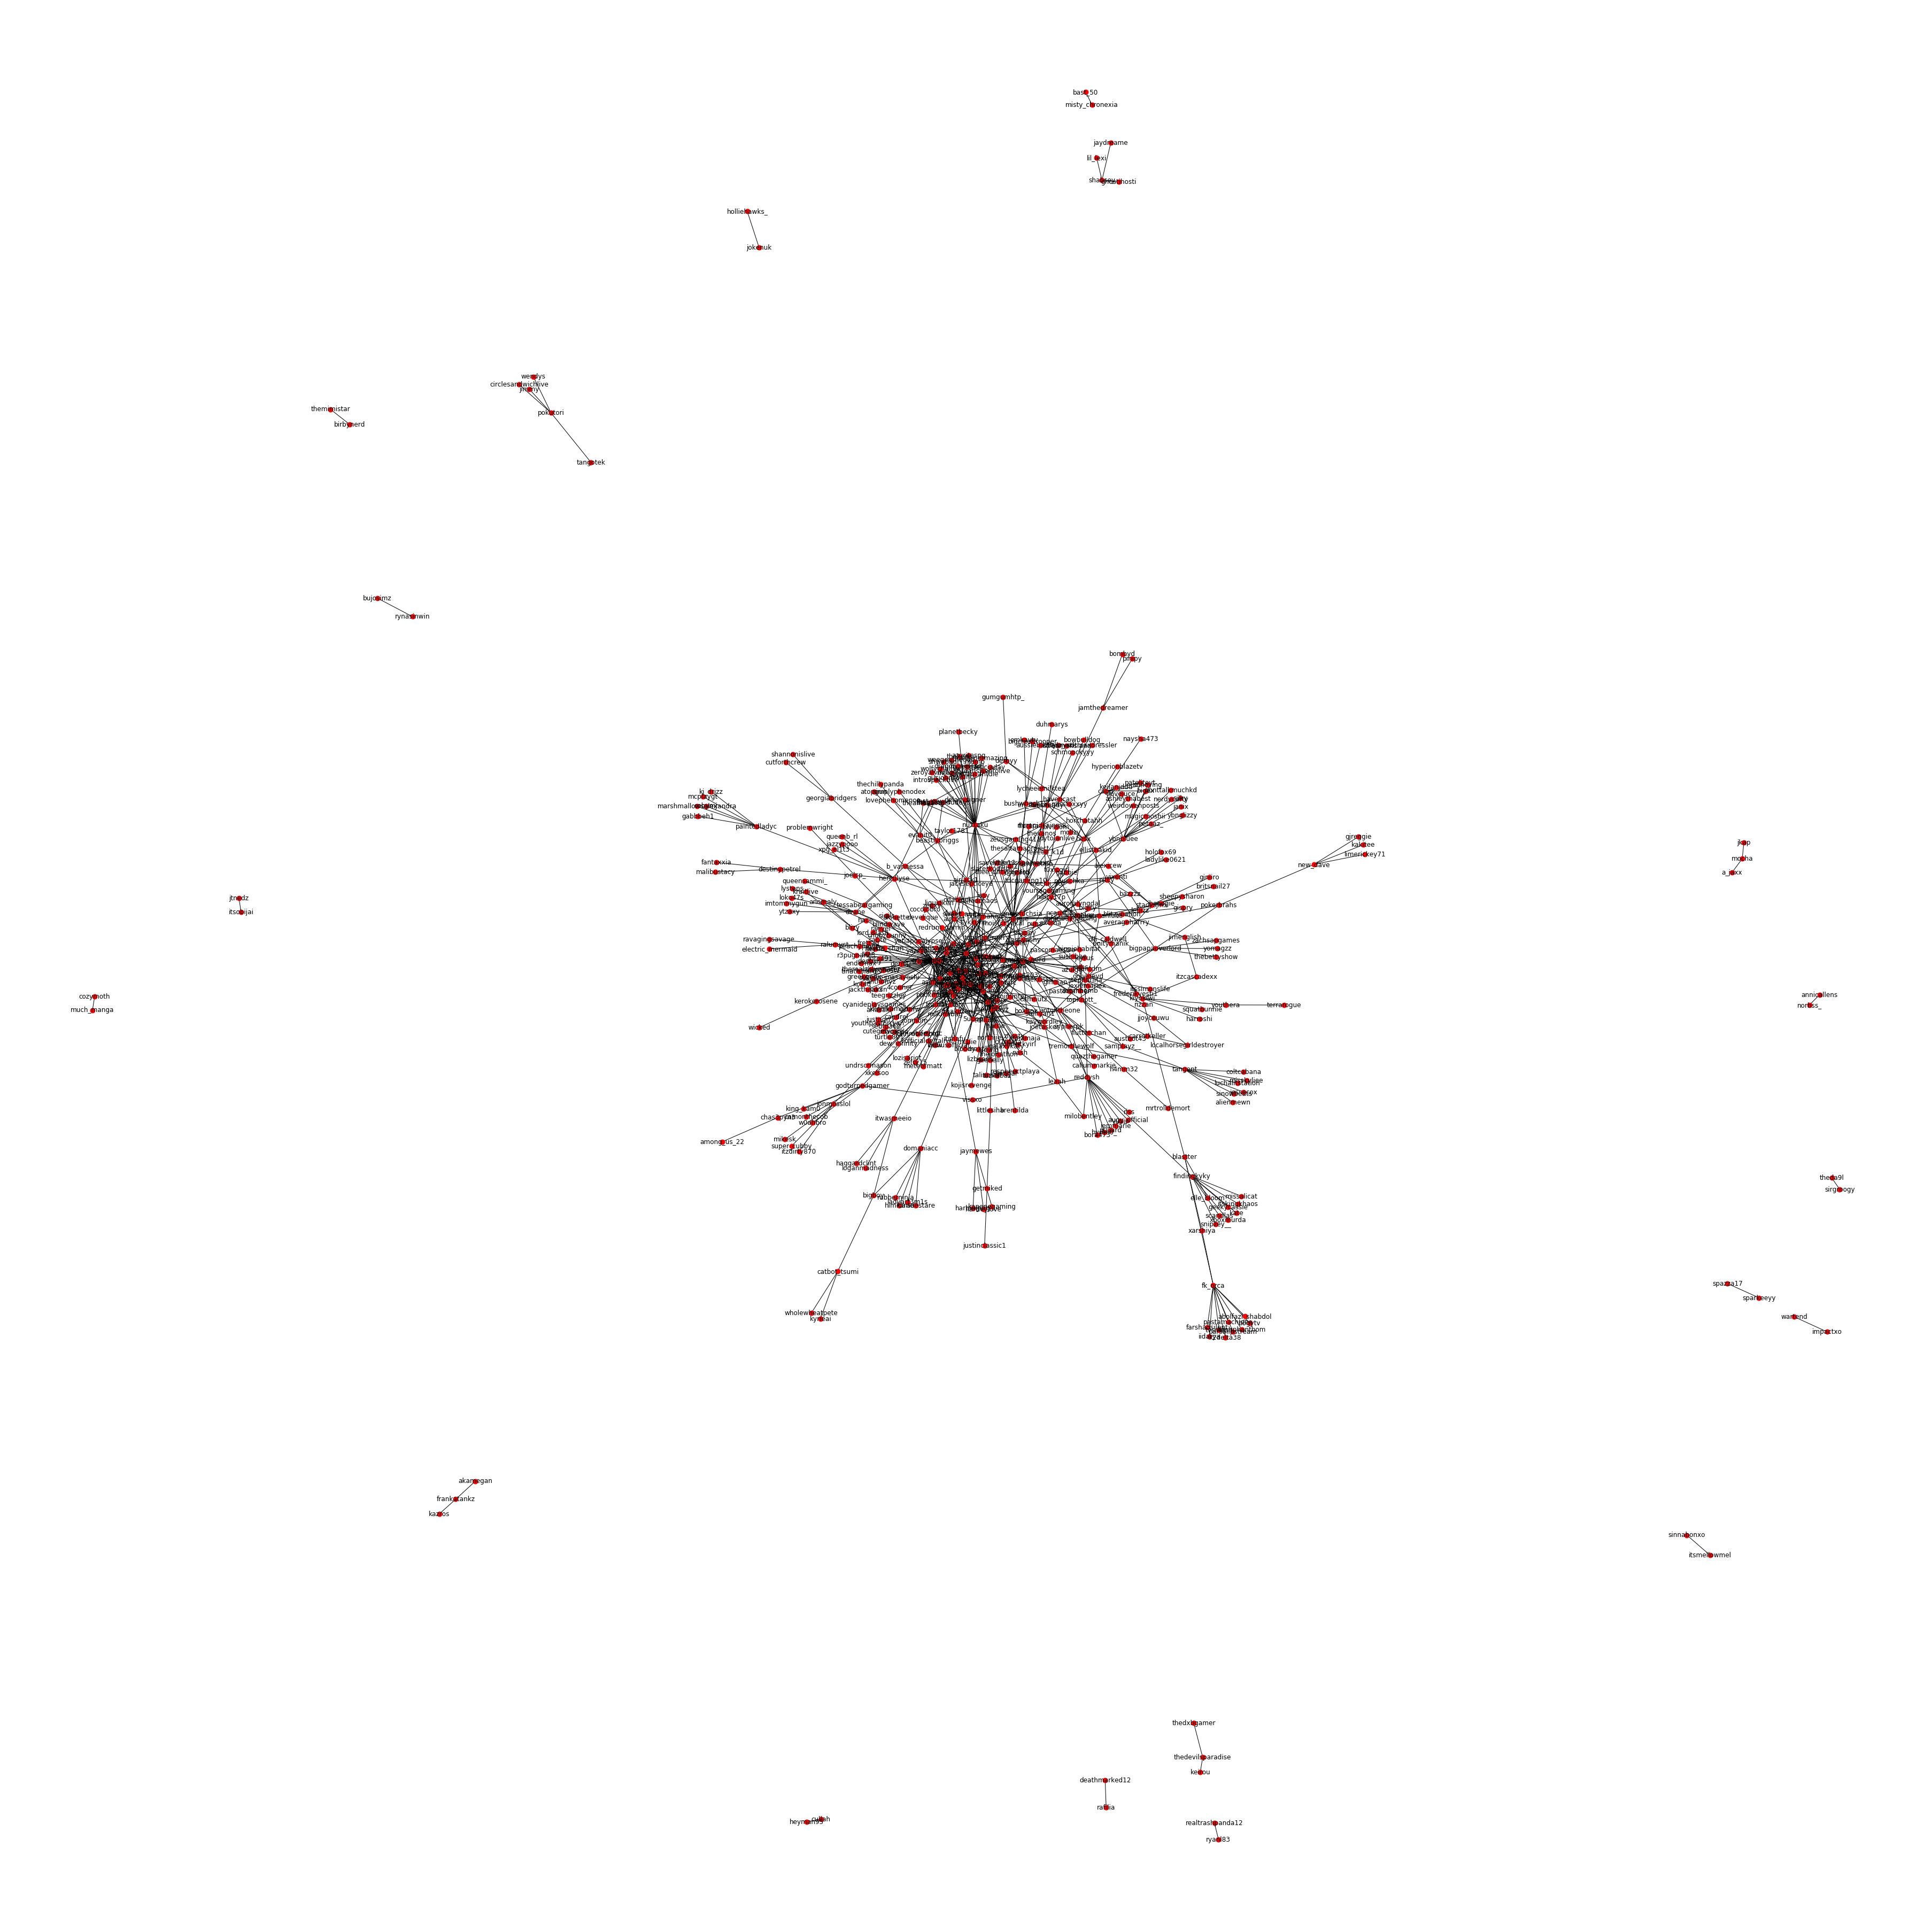

In [50]:
graph.plot()

In [52]:
def k_spanning_tree(st, k):
    edges = st.edges()
    edges.sort(key=lambda edge: edge.weight)
    for i in range(k):
        st.remove_edge(edges[i].nodes)
    return st

In [54]:
k_st = graph.copy()
k = 1
while True:
    k_st = k_spanning_tree(k_st, 1)
    groups = [group for group in k_st.disconnected_groups() if len(group) > 4]
    average_group_size = np.average([len(group) for group in groups])
    print(
        f"k: {k}, average group size: "
        f"{average_group_size}, "
        f"group count: {len(groups)}"
    )
    
    train_group = [group for group in k_st.disconnected_groups() if "trainwreckstv" in group][0]
    print(train_group)
    print()
    
    if len(train_group) < 10:
        break
    k += 1

k: 1, average group size: 215.5, group count: 2
{'harroshi', 'milobentley', 'redrum_gamin', 'auroralyngdal', 'kojisrevenge', 'suknives', 'atopgun', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'super_cubby', 'zoro491', 'm0xyy', 'itssimonslife', 'neytiri', 'frobotic', 'wolfeyvgc', 'unitymanik', 'pitcy', 'sick_nerd', 'squatbunnie', 'malibustacy', 'jazzypooo', 'ellisthakid', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'harrie', 'hyperionblazetv', 'camnutz', 't0xicgirl', 'odablock', 'ladyart3m1s', 'loganmadness', 'samplayz__', 'gispry', 'taliamar', 'dvane', 'imtinii', 'simplyphenodex', 'slaterkodish', 'oreoready', 'augy_official', 'ravagingsavage', 'yazzybug', 'simmotipo', 'holofox69', 'momo', 'respeeectplaya', 'souljaboy', 'peachypeytn', 'imtommygun', 'jorbs', 'dogofoo', 'ncaustic', 'maxtll', 'amirphanthom', 'blitzynation', 'tvsmash', 'herculyse', 'rocketmanluke', 'skylibs', 'lefiizz', 'bombyd', 'emkaytv', 'averageharrry', 'gjreggie', 'phokingtv_', 'geekycassie', 'lexiema

{'milobentley', 'redrum_gamin', 'auroralyngdal', 'kojisrevenge', 'bigboy', 'super_cubby', 'beastlybriggs', 'lovephenomenon', 'zoro491', 'm0xyy', 'itssimonslife', 'neytiri', 'frobotic', 'unitymanik', 'pitcy', 'sick_nerd', 'squatbunnie', 'ellisthakid', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'harrie', 'camnutz', 'ladyart3m1s', 'odablock', 'loganmadness', 'taliamar', 'dvane', 'imtinii', 'simplyphenodex', 'oreoready', 'yazzybug', 'simmotipo', 'momo', 'respeeectplaya', 'souljaboy', 'peachypeytn', 'imtommygun', 'jorbs', 'dogofoo', 'ncaustic', 'maxtll', 'amirphanthom', 'blitzynation', 'tvsmash', 'herculyse', 'rocketmanluke', 'skylibs', 'lefiizz', 'averageharrry', 'gjreggie', 'phokingtv_', 'lost_pause', 'ludwig', 'mafiajinx', 'keilanjddd', 'iidarya', 'planetbecky', 'natehill', 'wolfychulive', 'xqcow', 'jonmosslol', 'm0e_tv', 'sarite', 'onlyjoeyd', 'ibdw', 'jaketwiinsane', 'snappy', 'thee_dirty_beard', '5uppp', 'havencast', 'azuritespg', 'hace', 'pinipy', 'deansocool', 'sum

k: 245, average group size: 154.5, group count: 2
{'jjoyceuwu', 'rubberninja', 'w0ahbro', 'itshafu', 'hesx', 'mollzy', 'milobentley', 'redrum_gamin', 'sebto360', 'blindwave', 'kiyokiwi', 'itsenergie', 'kojisrevenge', 'pokimane', 'auroralyngdal', 'camonthecob', 'joelcp_', 'ytzaxy', 'scandlas', 'youthera', 'gumgumhtp_', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'alexicew', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'naysha473', 'blvssom', 'classyashy', 'itssimonslife', 'thump', 'wolfabelle', 'frobotic', 'neytiri', 'thexanos', 'mi1lie', 'yomagzz', 'zerkaa', 'unitymanik', 'stacysjinx', 'tdcgaming10', 'kyrieai', 'im_dontai', 'b_vannessa', 'sigils', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'squatbunnie', 'capp', 'tinath3lard', 'thesaitamaproject', 'trainwreckstv', 'ginman', 'wholewheatpete', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'olli_caldwell', 'carrotkeller', 'harrie', 'stepharina'

{'jjoyceuwu', 'rubberninja', 'w0ahbro', 'itshafu', 'hesx', 'mollzy', 'redrum_gamin', 'sebto360', 'kiyokiwi', 'itsenergie', 'auroralyngdal', 'pokimane', 'kojisrevenge', 'camonthecob', 'joelcp_', 'ytzaxy', 'scandlas', 'youthera', 'gumgumhtp_', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'horchatahh', 'alexicew', 'endernax', 'm0xyy', 'naysha473', 'blvssom', 'freyzplayz', 'classyashy', 'itssimonslife', 'wolfabelle', 'thump', 'neytiri', 'frobotic', 'thexanos', 'yomagzz', 'zerkaa', 'unitymanik', 'kyrieai', 'tdcgaming10', 'stacysjinx', 'im_dontai', 'sigils', 'b_vannessa', 'pitcy', 'issy', 'jacksepticeye', 'sick_nerd', 'squatbunnie', 'capp', 'tinath3lard', 'thesaitamaproject', 'trainwreckstv', 'ginman', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'olli_caldwell', 'carrotkeller', 'harrie', 'stepharina', 'weirdowenposts', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'problemwright', 'ladyart3m1s', 'gabbie

k: 341, average group size: 124.0, group count: 2
{'jjoyceuwu', 'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'mollzy', 'kiyokiwi', 'itsenergie', 'auroralyngdal', 'pokimane', 'kojisrevenge', 'scandlas', 'youthera', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'alexicew', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'naysha473', 'blvssom', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'thexanos', 'yomagzz', 'kyrieai', 'stacysjinx', 'tdcgaming10', 'im_dontai', 'sigils', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'squatbunnie', 'capp', 'tinath3lard', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'carrotkeller', 'stepharina', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'ladyart3m1s', 'gabbie', 'odablock', 'loganmadness', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'sweet_anita', 'dvane', 'sykk

k: 363, average group size: 116.5, group count: 2
{'jjoyceuwu', 'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'mollzy', 'itsenergie', 'auroralyngdal', 'pokimane', 'scandlas', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'alexicew', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'naysha473', 'blvssom', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'thexanos', 'yomagzz', 'stacysjinx', 'tdcgaming10', 'im_dontai', 'sigils', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'quazthegamer', 'catbot_tsumi', 'lolshikamaru', 'carrotkeller', 'stepharina', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'ladyart3m1s', 'gabbie', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'sweet_anita', 'dvane', 'sykkuno', 'lospollostv', 'jamthedreamer', 'reddysh', 'anthonyz', 'imtinii', 'simplyphenodex', 'liquid

{'jjoyceuwu', 'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'mollzy', 'itsenergie', 'auroralyngdal', 'pokimane', 'scandlas', 'bigboy', 'beastlybriggs', 'lovephenomenon', 'horchatahh', 'alexicew', 'endernax', 'm0xyy', 'freyzplayz', 'naysha473', 'blvssom', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'thexanos', 'yomagzz', 'stacysjinx', 'tdcgaming10', 'im_dontai', 'sigils', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'lolshikamaru', 'carrotkeller', 'stepharina', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'ladyart3m1s', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'sweet_anita', 'dvane', 'sykkuno', 'lospollostv', 'jamthedreamer', 'anthonyz', 'reddysh', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'ariasaki', 'yazzybug', 'simmotipo', 'domaniacc', 'brookea

k: 403, average group size: 70.66666666666667, group count: 3
{'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'naysha473', 'blvssom', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'thexanos', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'ladyart3m1s', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'lospollostv', 'jamthedreamer', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'ariasaki', 'yazzybug', 'simmotipo', 'domaniacc', 'brookeab', 'momo', 'respeeectplaya', 'jorbs', 'imtommygun', 'easyrod', 'sypmtem', 'annoying', 'blitzynation', 'blizy'

{'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'blvssom', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'thexanos', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'lospollostv', 'jamthedreamer', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'brookeab', 'momo', 'respeeectplaya', 'jorbs', 'imtommygun', 'easyrod', 'sypmtem', 'annoying', 'blitzynation', 'blizy', 'pascomaestro', 'missfoxxyy', 'herculyse', 'masterfiend', 'kaywordley', 'rocketmanluke', 'bigpapaove

k: 439, average group size: 62.0, group count: 3
{'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'jamthedreamer', 'sykkuno', 'lospollostv', 'dvane', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'brookeab', 'momo', 'respeeectplaya', 'jorbs', 'imtommygun', 'easyrod', 'sypmtem', 'blitzynation', 'blizy', 'pascomaestro', 'missfoxxyy', 'herculyse', 'masterfiend', 'kaywordley', 'rocketmanluke

{'rubberninja', 'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'endernax', 'm0xyy', 'freyzplayz', 'classyashy', 'wolfabelle', 'thump', 'neytiri', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'gabbbeh1', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'odablock', 'northiie', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'jamthedreamer', 'sykkuno', 'lospollostv', 'dvane', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'momo', 'respeeectplaya', 'jorbs', 'imtommygun', 'easyrod', 'sypmtem', 'blitzynation', 'blizy', 'pascomaestro', 'missfoxxyy', 'herculyse', 'masterfiend', 'kaywordley', 'rocketmanluke', 'bigpapaoverlord', 'skylibs', 'lefiizz', 'gjreggie', 'bazz

k: 471, average group size: 53.333333333333336, group count: 3
{'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'm0xyy', 'freyzplayz', 'classyashy', 'wolfabelle', 'thump', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'issy', 'pitcy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'gabbbeh1', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'jamthedreamer', 'sykkuno', 'lospollostv', 'dvane', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'momo', 'respeeectplaya', 'jorbs', 'imtommygun', 'easyrod', 'sypmtem', 'blitzynation', 'pascomaestro', 'missfoxxyy', 'herculyse', 'masterfiend', 'kaywordley', 'rocketmanluke', 'bigpapaoverlord', 'skylibs', 'lefiizz', 'gjreggie', '

k: 487, average group size: 50.0, group count: 3
{'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'pitcy', 'issy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'gabbbeh1', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'bigity', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'gunsworld', 'asimuk', 'antontheone', 'taliamar', 'jamthedreamer', 'sykkuno', 'lospollostv', 'dvane', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'momo', 'imtommygun', 'easyrod', 'sypmtem', 'blitzynation', 'pascomaestro', 'herculyse', 'missfoxxyy', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'lefiizz', 'gjreggie', 'bazzzz', 'romnom_', 'lozisariot', 'austbot43', 'lycheeemilktea', 'swifto

{'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'im_dontai', 'b_vannessa', 'pitcy', 'issy', 'jacksepticeye', 'sick_nerd', 'capp', 'thesaitamaproject', 'trainwreckstv', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'jamthedreamer', 'sykkuno', 'lospollostv', 'dvane', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'imtommygun', 'easyrod', 'sypmtem', 'blitzynation', 'pascomaestro', 'herculyse', 'missfoxxyy', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'lefiizz', 'gjreggie', 'bazzzz', 'romnom_', 'lozisariot', 'lycheeemilktea', 'swiftor', 'dantdm', 'broskiesstudios', 'lost_pause', 'mafiajinx', 'jordansweetolive', 'keilanjddd', 'feliciaday

{'itshafu', 'hesx', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'horchatahh', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'im_dontai', 'issy', 'jacksepticeye', 'sick_nerd', 'capp', 'trainwreckstv', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'lospollostv', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'imtommygun', 'easyrod', 'blitzynation', 'pascomaestro', 'herculyse', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'gjreggie', 'romnom_', 'lozisariot', 'lycheeemilktea', 'swiftor', 'dantdm', 'broskiesstudios', 'lost_pause', 'mafiajinx', 'jordansweetolive', 'keilanjddd', 'feliciaday', 'itssky', 'galaxykaty', 'derbyy', 'paintedladyc', 'wolfychulive', 'xqcow', 'callux', 'jonmosslol', 'tops

k: 533, average group size: 30.25, group count: 4
{'itshafu', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'im_dontai', 'issy', 'jacksepticeye', 'trainwreckstv', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'anthonyz', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'imtommygun', 'easyrod', 'blitzynation', 'pascomaestro', 'herculyse', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'gjreggie', 'romnom_', 'lozisariot', 'lycheeemilktea', 'swiftor', 'broskiesstudios', 'lost_pause', 'mafiajinx', 'jordansweetolive', 'feliciaday', 'itssky', 'galaxykaty', 'derbyy', 'paintedladyc', 'wolfychulive', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'fuse', 'm0e_tv', 'd

k: 548, average group size: 28.5, group count: 4
{'itshafu', 'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'beastlybriggs', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'issy', 'trainwreckstv', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'imtinii', 'simplyphenodex', 'oreoready', 'svennoss', 'yazzybug', 'simmotipo', 'domaniacc', 'imtommygun', 'easyrod', 'blitzynation', 'pascomaestro', 'herculyse', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'gjreggie', 'romnom_', 'lycheeemilktea', 'swiftor', 'broskiesstudios', 'lost_pause', 'mafiajinx', 'jordansweetolive', 'feliciaday', 'itssky', 'galaxykaty', 'derbyy', 'paintedladyc', 'wolfychulive', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'fuse', 'm0e_tv', 'dbfanboygaming', 'bushwhack18', 'pokerbrahs', 'onlyjoeyd',

k: 563, average group size: 26.5, group count: 4
{'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'tdcgaming10', 'issy', 'trainwreckstv', 'ellisthakid', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'mrconrem', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'dvane', 'sykkuno', 'imtinii', 'oreoready', 'svennoss', 'simmotipo', 'domaniacc', 'imtommygun', 'easyrod', 'blitzynation', 'pascomaestro', 'herculyse', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'gjreggie', 'romnom_', 'lycheeemilktea', 'swiftor', 'broskiesstudios', 'mafiajinx', 'itssky', 'galaxykaty', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'fuse', 'm0e_tv', 'dbfanboygaming', 'bushwhack18', 'pokerbrahs', 'onlyjoeyd', 'jaketwiinsane', 'snappy', '5uppp', 'aipha', 'havencast', 'jellypeanut', 'vikramafc', 'moonit', 'deansocool', 'muchii_xo'

k: 576, average group size: 20.0, group count: 5
{'redrum_gamin', 'itsenergie', 'auroralyngdal', 'pokimane', 'bigboy', 'm0xyy', 'freyzplayz', 'wolfabelle', 'thump', 'issy', 'trainwreckstv', 'blaustoise', 'kj_drizz', 'tessabeargaming', 'vondilltv', 'catbot_tsumi', 'camnutz', 'itwasmeeio', 'odablock', 'papa_gut2032', 'elllum', 'asimuk', 'antontheone', 'taliamar', 'sykkuno', 'imtinii', 'svennoss', 'domaniacc', 'easyrod', 'blitzynation', 'pascomaestro', 'herculyse', 'masterfiend', 'kaywordley', 'bigpapaoverlord', 'skylibs', 'gjreggie', 'romnom_', 'lycheeemilktea', 'swiftor', 'broskiesstudios', 'mafiajinx', 'itssky', 'galaxykaty', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'fuse', 'm0e_tv', 'dbfanboygaming', 'pokerbrahs', 'onlyjoeyd', 'jaketwiinsane', 'snappy', '5uppp', 'aipha', 'jellypeanut', 'vikramafc', 'moonit', 'deansocool', 'muchii_xo', 'yassuo', 'nash', 'topknott_', 'harry17p', 'limerickey71', 'harambe', 'miniminter', 'itssliker', 'tradi3', 'mezzarthy

{'lycheeemilktea', 'muchii_xo', 'odablock', 'deansocool', 'yassuo', 'papa_gut2032', 'redrum_gamin', 'swiftor', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'auroralyngdal', 'itsenergie', 'pokimane', 'sykkuno', 'topknott_', 'bigboy', 'harry17p', 'imtinii', 'limerickey71', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'thump', 'wolfabelle', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'miniminter', 'domaniacc', 'fuse', 'dbfanboygaming', 'pokerbrahs', 'issy', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'snappy', 'mezzarthy', 'pascomaestro', 'herculyse', 'blaustoise', 'punz', 'leaah', 'masterfiend', 'vondilltv', 'kaywordley', 'tessabeargaming', 'catbot_tsumi', '5uppp', 'aipha', 'bigpapaoverlord', 'skylibs', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'itwasmeeio'}

k: 591, average group size: 21.75, group count: 4
{'lycheeemilktea', 'muchi

k: 605, average group size: 25.666666666666668, group count: 3
{'lycheeemilktea', 'muchii_xo', 'odablock', 'swiftor', 'papa_gut2032', 'yassuo', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'auroralyngdal', 'itsenergie', 'topknott_', 'bigboy', 'harry17p', 'imtinii', 'itwasmeeio', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'jonmosslol', 'topsnipergirl', 'miniminter', 'fuse', 'domaniacc', 'dbfanboygaming', 'issy', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'snappy', 'pascomaestro', 'mezzarthy', 'herculyse', 'blaustoise', 'punz', 'leaah', 'tessabeargaming', 'vondilltv', 'masterfiend', 'catbot_tsumi', '5uppp', 'aipha', 'bigpapaoverlord', 'skylibs', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'deansocool'}

k: 606, average group size: 25.666666666666668, group count: 3
{'lycheeemilktea',

k: 618, average group size: 24.0, group count: 3
{'lycheeemilktea', 'muchii_xo', 'odablock', 'deansocool', 'swiftor', 'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'itsenergie', 'topknott_', 'bigboy', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'wolfabelle', 'svennoss', 'thump', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'miniminter', 'topsnipergirl', 'jonmosslol', 'domaniacc', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'pascomaestro', 'mezzarthy', 'herculyse', 'blaustoise', 'punz', 'tessabeargaming', 'masterfiend', 'vondilltv', 'catbot_tsumi', 'aipha', '5uppp', 'bigpapaoverlord', 'skylibs', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'itwasmeeio'}

k: 619, average group size: 24.0, group count: 3
{'lycheeemilktea', 'muchii_xo', 'odablock', 'deansocool', 'swiftor', 'yassuo', 'papa_gut2032', 'el

k: 632, average group size: 32.0, group count: 2
{'lycheeemilktea', 'muchii_xo', 'deansocool', 'swiftor', 'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'itsenergie', 'topknott_', 'bigboy', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'wolfabelle', 'svennoss', 'thump', 'derbyy', 'paintedladyc', 'xqcow', 'callux', 'miniminter', 'jonmosslol', 'domaniacc', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'pascomaestro', 'mezzarthy', 'herculyse', 'blaustoise', 'punz', 'tessabeargaming', 'masterfiend', 'catbot_tsumi', 'aipha', '5uppp', 'bigpapaoverlord', 'skylibs', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'itwasmeeio'}

k: 633, average group size: 32.0, group count: 2
{'lycheeemilktea', 'muchii_xo', 'deansocool', 'swiftor', 'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx

{'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'itsenergie', 'topknott_', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'callux', 'miniminter', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'pascomaestro', 'mezzarthy', 'blaustoise', 'masterfiend', 'aipha', '5uppp', 'bigpapaoverlord', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'deansocool'}

k: 646, average group size: 20.0, group count: 3
{'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'nash', 'mafiajinx', 'antontheone', 'itsenergie', 'topknott_', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'callux', 'miniminter', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'pas

k: 659, average group size: 24.5, group count: 2
{'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'mafiajinx', 'itsenergie', 'topknott_', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'callux', 'miniminter', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', 'pascomaestro', 'mezzarthy', 'blaustoise', 'masterfiend', '5uppp', 'aipha', 'bigpapaoverlord', 'jellypeanut', 'vikramafc', 'gjreggie', 'dakotaz', 'camnutz', 'moonit', 'romnom_', 'new_dave', 'deansocool'}

k: 660, average group size: 24.5, group count: 2
{'yassuo', 'papa_gut2032', 'elllum', 'broskiesstudios', 'asimuk', 'mafiajinx', 'itsenergie', 'topknott_', 'harry17p', 'imtinii', 'm0xyy', 'freyzplayz', 'galaxykaty', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'callux', 'miniminter', 'dbfanboygaming', 'pokerbrahs', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'jaketwiinsane', '

k: 685, average group size: 28.0, group count: 1
{'yassuo', 'elllum', 'broskiesstudios', 'asimuk', 'mafiajinx', 'itsenergie', 'imtinii', 'm0xyy', 'freyzplayz', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'miniminter', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'mezzarthy', 'blaustoise', '5uppp', 'aipha', 'jellypeanut', 'vikramafc', 'dakotaz', 'romnom_', 'deansocool'}

k: 686, average group size: 28.0, group count: 1
{'yassuo', 'elllum', 'broskiesstudios', 'asimuk', 'mafiajinx', 'itsenergie', 'imtinii', 'm0xyy', 'freyzplayz', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow', 'miniminter', 'itssliker', 'easyrod', 'trainwreckstv', 'onlyjoeyd', 'mezzarthy', 'blaustoise', '5uppp', 'aipha', 'jellypeanut', 'vikramafc', 'dakotaz', 'romnom_', 'deansocool'}

k: 687, average group size: 28.0, group count: 1
{'yassuo', 'elllum', 'broskiesstudios', 'asimuk', 'mafiajinx', 'itsenergie', 'imtinii', 'm0xyy', 'freyzplayz', 'harambe', 'svennoss', 'wolfabelle', 'thump', 'xqcow',

k: 711, average group size: 10.5, group count: 2
{'xqcow', 'mezzarthy', 'yassuo', '5uppp', 'aipha', 'itssliker', 'm0xyy', 'jellypeanut', 'easyrod', 'asimuk', 'trainwreckstv', 'thump', 'mafiajinx', 'romnom_', 'deansocool'}

k: 712, average group size: 10.5, group count: 2
{'xqcow', 'mezzarthy', 'yassuo', '5uppp', 'aipha', 'itssliker', 'm0xyy', 'jellypeanut', 'easyrod', 'asimuk', 'trainwreckstv', 'thump', 'mafiajinx', 'romnom_', 'deansocool'}

k: 713, average group size: 10.0, group count: 2
{'xqcow', 'mezzarthy', 'yassuo', '5uppp', 'aipha', 'itssliker', 'm0xyy', 'jellypeanut', 'easyrod', 'asimuk', 'trainwreckstv', 'thump', 'mafiajinx', 'romnom_'}

k: 714, average group size: 9.5, group count: 2
{'xqcow', 'mezzarthy', 'yassuo', '5uppp', 'aipha', 'itssliker', 'm0xyy', 'jellypeanut', 'easyrod', 'asimuk', 'trainwreckstv', 'thump', 'mafiajinx', 'romnom_'}

k: 715, average group size: 9.5, group count: 2
{'xqcow', 'mezzarthy', 'yassuo', '5uppp', 'aipha', 'itssliker', 'm0xyy', 'jellypeanut', '